In [1]:
print("hello world")

hello world


In [2]:
import datetime as dt

import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers, regularizers
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.seasonal import seasonal_decompose

from functions import (bucketize_column, plot_the_loss_curve, create_model,
                       train_model, replace_with_linear_interpolation,
                       plot_the_loss_curves, tf_error, evaluate_model, predict_model,
                       np_error)

plt.rcParams.update({'figure.figsize': (7,7)})

In [3]:
def my_decompose(values, period, model='additive'):
    'multiplicative'
    result = seasonal_decompose(
        values, model=model, extrapolate_trend='freq', period=eval(period))

    # result.plot().suptitle(f'{model} Decompose {period}', fontsize=22)

    return result


def plot_seasonal(seasonal, period):
    fig, axs = plt.subplots(1, 2, figsize=(16,7))
    sections = np.split(seasonal, range(period, len(seasonal) - len(seasonal)%period, period))
    if len(sections[-1]) != period:
        del sections[-1]
    mean = np.mean(sections, axis=0)

    for section in sections:
        axs[0].plot(section)

    print(mean - seasonal[:period])

    axs[1].plot(seasonal)
    plt.show()


def apply(period, values):
    decomposed = my_decompose(values, period)
    decomposed.plot().suptitle(f'additive Decompose {period}', fontsize=22)
    plt.show()

    plot_seasonal(np.array(decomposed.trend), eval(period))
    plot_seasonal(np.array(decomposed.seasonal), eval(period))
    plot_seasonal(np.array(decomposed.resid), eval(period))

    values = values - decomposed.trend
    values = values - decomposed.seasonal

    return values, decomposed

In [4]:
train = pd.read_csv("train.csv")
out = pd.read_csv("out.csv")
train




,datetime,total
0,01.01.2005 00:00:00,?
1,01.01.2005 01:00:00,154140
2,01.01.2005 02:00:00,157818
3,01.01.2005 03:00:00,149311
4,01.01.2005 04:00:00,138282
...,...,...
35059,31.12.2008 19:00:00,249376
35060,31.12.2008 20:00:00,246511
35061,31.12.2008 21:00:00,226469
35062,31.12.2008 22:00:00,199907


In [5]:
out[70:90]


,Unnamed: 0,datetime,total,data,time,isHoliday
70,70,2005-01-03 22:00:00,29274.711147,2005-01-03,22:00:00,1
71,71,2005-01-03 23:00:00,5241.375880,2005-01-03,23:00:00,1
72,72,2005-01-04 00:00:00,-21508.959387,2005-01-04,00:00:00,1
73,73,2005-01-04 01:00:00,-51766.294654,2005-01-04,01:00:00,1
74,74,2005-01-04 02:00:00,-71581.629921,2005-01-04,02:00:00,1
75,75,2005-01-04 03:00:00,-80295.965188,2005-01-04,03:00:00,1
76,76,2005-01-04 04:00:00,-82249.300455,2005-01-04,04:00:00,1
77,77,2005-01-04 05:00:00,-77722.635722,2005-01-04,05:00:00,1
78,78,2005-01-04 06:00:00,-66898.970989,2005-01-04,06:00:00,1
79,79,2005-01-04 07:00:00,-50018.306256,2005-01-04,07:00:00,1


In [6]:
train['total'].replace("?", -1000, inplace=True)
train['total'] = train['total'].astype(np.int32)

train[train['total'] <= 0]

,datetime,total
0,01.01.2005 00:00:00,-1000
3936,14.06.2005 00:00:00,-1000
3944,14.06.2005 08:00:00,-1000
3970,15.06.2005 10:00:00,-1000
3973,15.06.2005 13:00:00,-1000
...,...,...
34329,01.12.2008 09:00:00,-1000
34464,07.12.2008 00:00:00,-1000
34475,07.12.2008 11:00:00,-1000
34477,07.12.2008 13:00:00,-1000


In [7]:
train

,datetime,total
0,01.01.2005 00:00:00,-1000
1,01.01.2005 01:00:00,154140
2,01.01.2005 02:00:00,157818
3,01.01.2005 03:00:00,149311
4,01.01.2005 04:00:00,138282
...,...,...
35059,31.12.2008 19:00:00,249376
35060,31.12.2008 20:00:00,246511
35061,31.12.2008 21:00:00,226469
35062,31.12.2008 22:00:00,199907


In [8]:
time_format = "%d.%m.%Y %H:%M:%S"
train["datetime"] = [dt.datetime.strptime(s, time_format) for s in train["datetime"]]
train.sort_values(by=["datetime"], inplace=True)

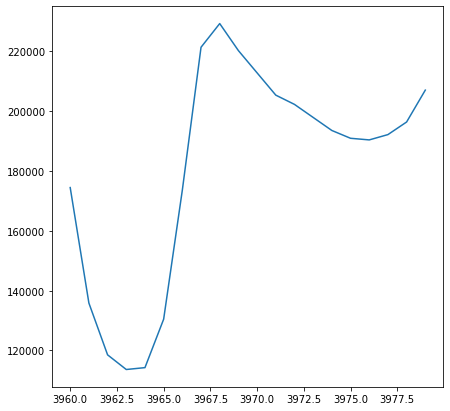

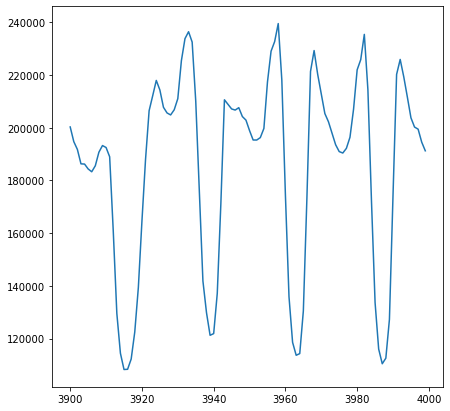

In [9]:
# replace non-positive values with linear interpolation
replace_with_linear_interpolation(train, train['total'] <= 0)

plt.plot(train[3960:3980]["total"])
plt.show()
plt.plot(train[3900:4000]["total"])
plt.show()

In [10]:
original_total = train["total"].copy()

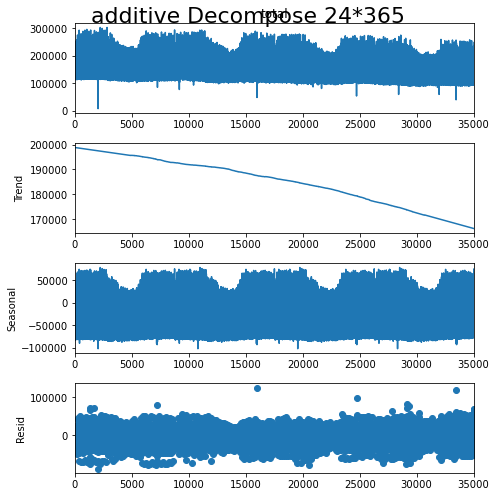

[-6162.45786499 -6162.87260543 -6163.15738011 ... -7285.7814688
 -7284.82929033 -7284.50351979]


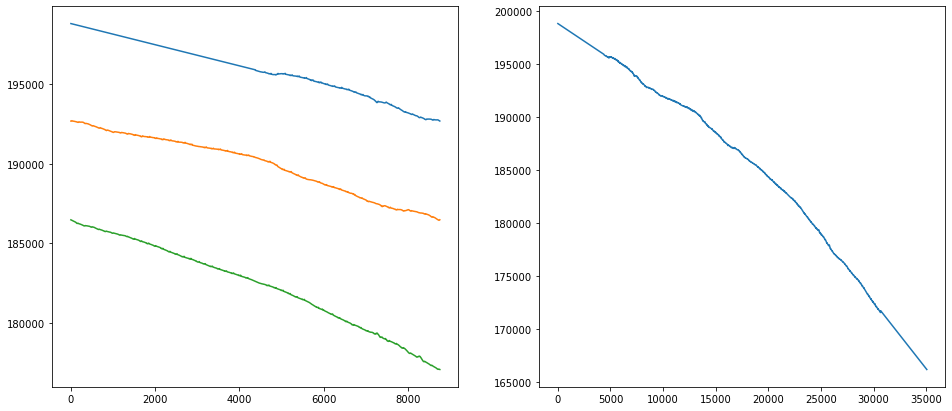

[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 7.27595761e-12
 0.00000000e+00 0.00000000e+00]


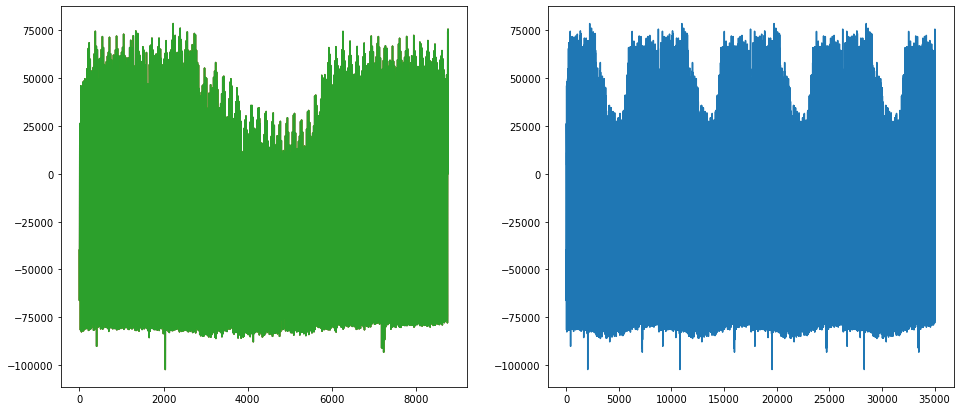

[-3571.20880168  1121.53927209  -731.17595322 ... -4310.88519787
 -1053.17070967  1065.17018645]


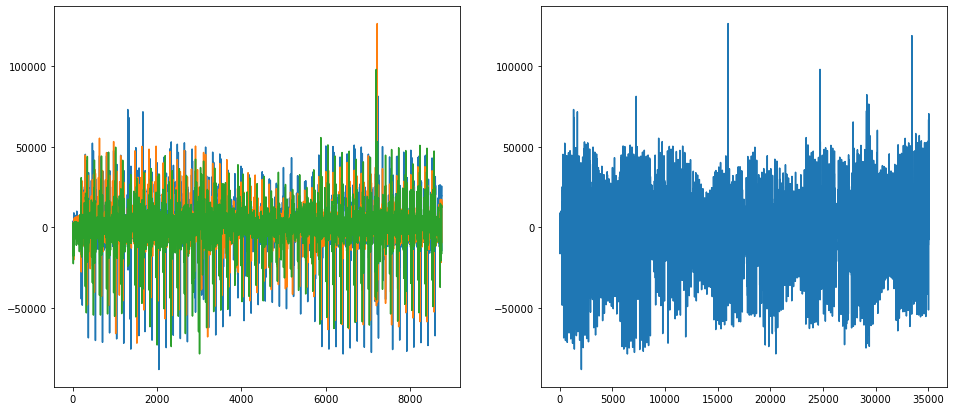

In [11]:
_, year_decomposed = apply("24*365", train["total"])

In [12]:
global_trend = year_decomposed.trend
train['total'] -= global_trend

In [13]:
global_trend_shift = np.mean(global_trend)
global_trend -= global_trend_shift

In [14]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c


def func(x, a, b, c, e, f):
    return a * np.exp(-b * x) + c + e * (x + f)**2


# def func(x, a, b, c, d, e):
#     return a + b*x + c*x**2 + d*x**3 + e*x**4  # a*np.exp(-b*x) +


# def func(x, a, b, c, e, f, g, h):
#     return a * np.exp(-b * x) + c + e * f**2 + g * h**3


# def func(x, a, b, offset):
#     return 1.0 / (1.0 + np.exp(-a * (x-b))) + offset

# method : {'lm', 'trf', 'dogbox'}
popt, pcov = curve_fit(func, global_trend.index, global_trend)#, method='dogbox')
print(popt)
# [ 6.80965581e+02  5.54983660e+05  2.01353392e+05 -1.40515861e-05 1.50944272e+04]

<ipython-input-14-49c0992b6259>:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c + e * (x + f)**2


[ 6.80965587e+02  6.90115549e+05  1.63968907e+04 -1.40515861e-05
  1.50944271e+04]


C:\Users\gleb\anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


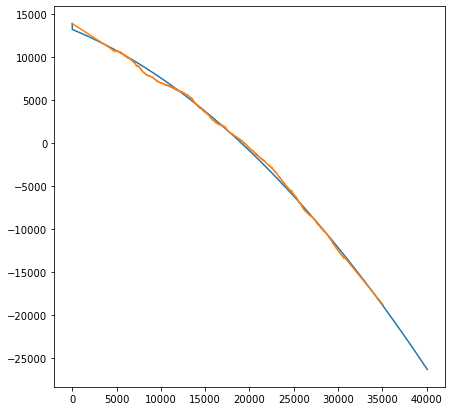

In [15]:
_x_data = np.arange(len(global_trend) + 5000)
plt.plot(_x_data, func(_x_data, *popt),
         label=f'fit: {popt}')#a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.plot(global_trend, label="data")
plt.show()

In [16]:
with open("a.txt", "w", encoding="utf-8") as f:
    f.write(", ".join(list(map(str, zip(global_trend.index, global_trend)))))

In [17]:
# replace outlier values with linear interpolation
print(len(train[train['total'] < -100_000]) / len(train))

replace_with_linear_interpolation(train, train['total'] < -100_000)

0.0002851927903262606


In [18]:
train['total'].describe()

count     35064.000000
mean        182.310707
std       44510.593192
min      -98843.734361
25%      -27666.754693
50%       11630.643215
75%       32287.640240
max      105232.374088
Name: total, dtype: float64

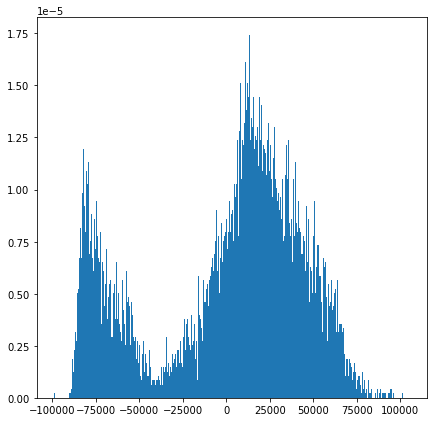

In [19]:
plt.hist(train["total"], 1500, density=True)
plt.show()

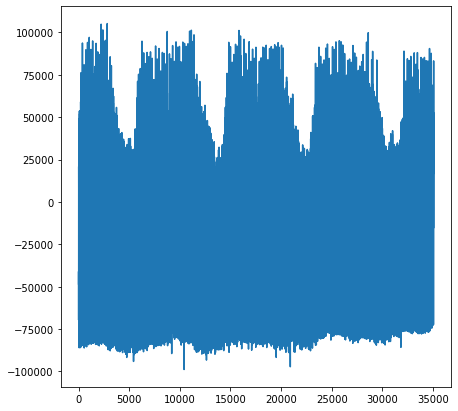

In [20]:
plt.plot(train["total"])

24*365


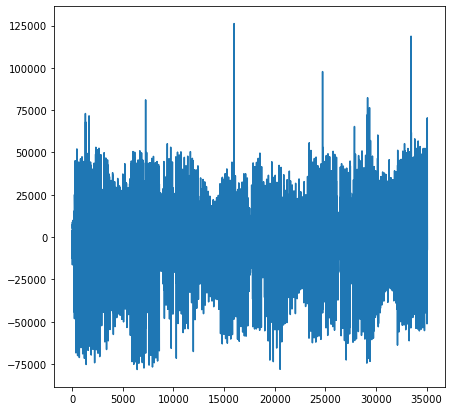

12


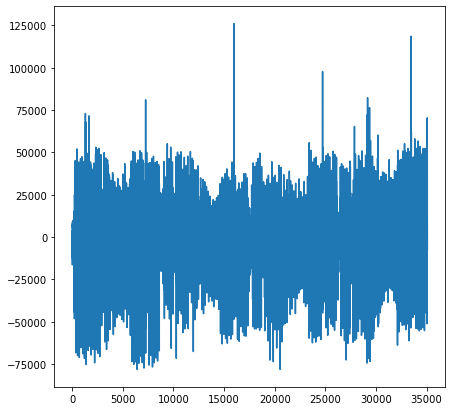

24


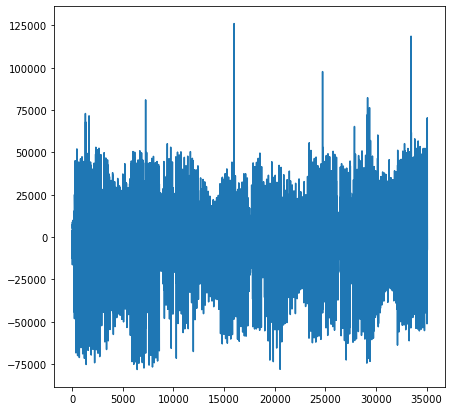

24*7*4


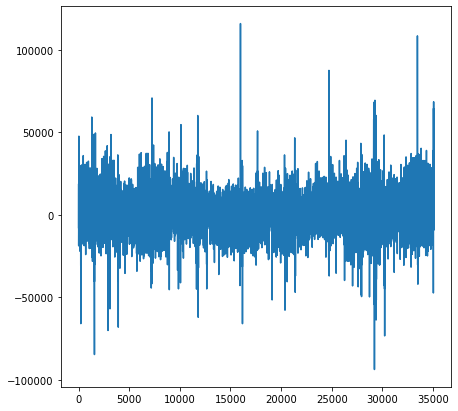

24*365//4


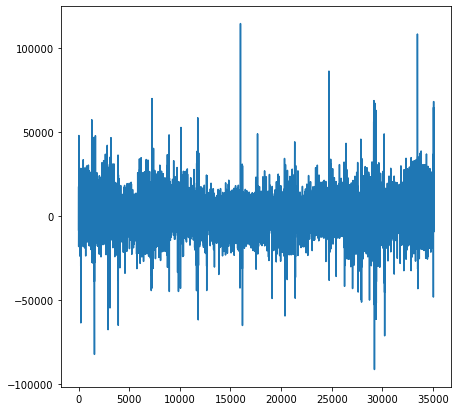

24*365//2


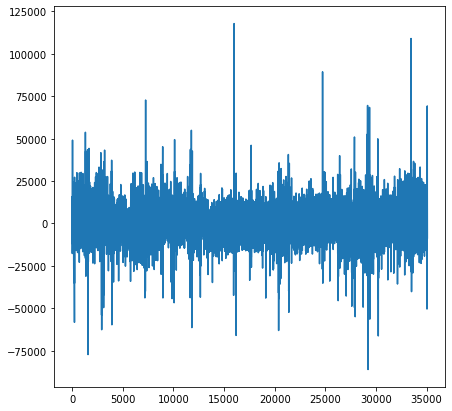

24*365


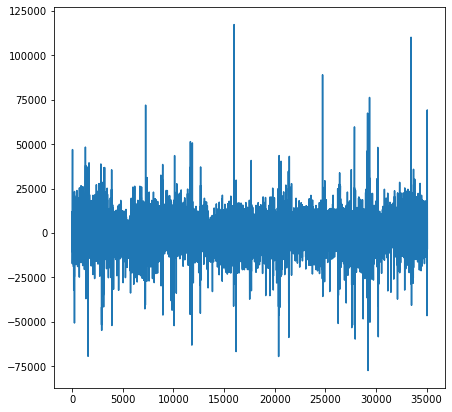

12


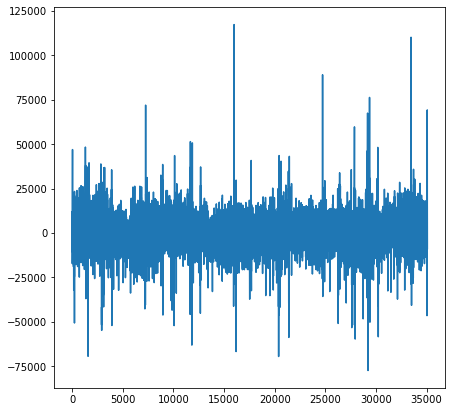

24


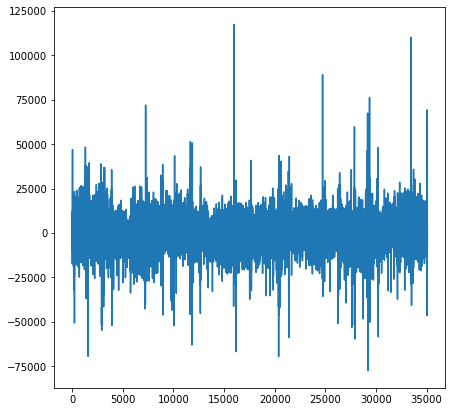

24*7*4


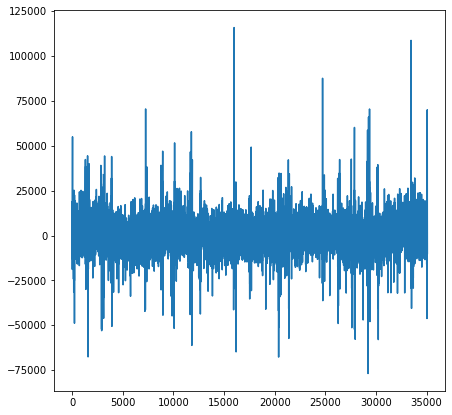

24*365//4


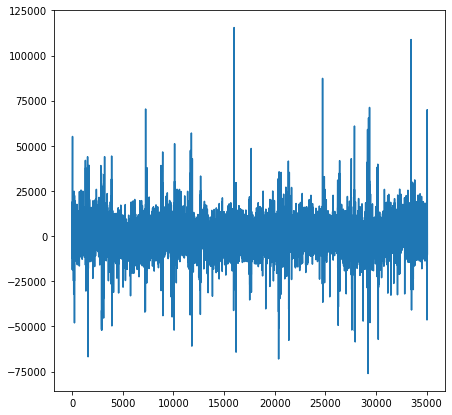

24*365//2


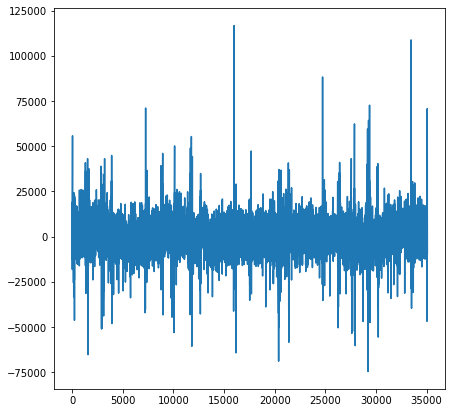

24*365


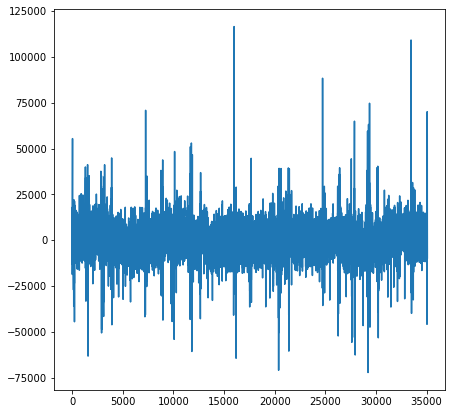

12


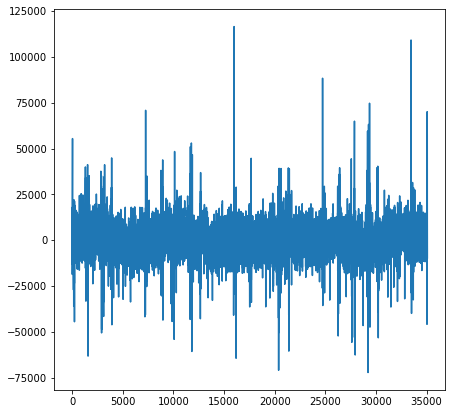

24


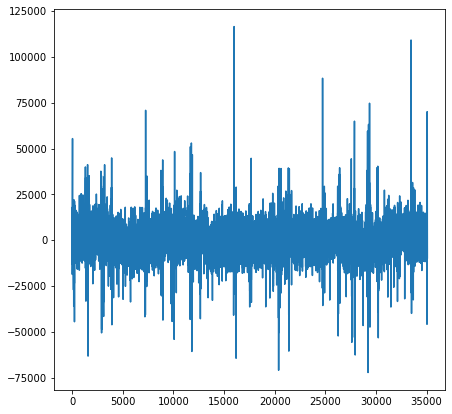

24*7*4


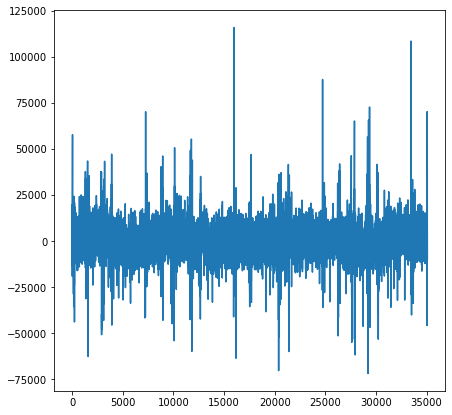

24*365//4


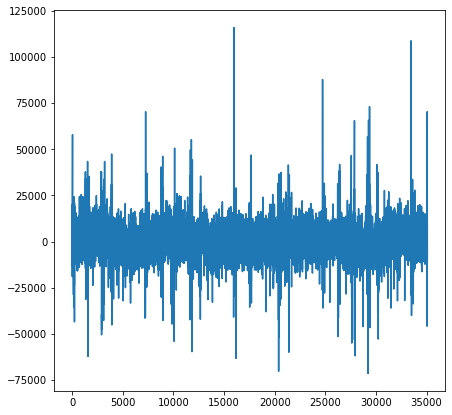

24*365//2


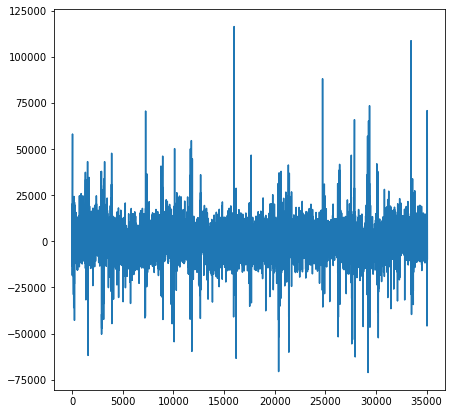

24*365


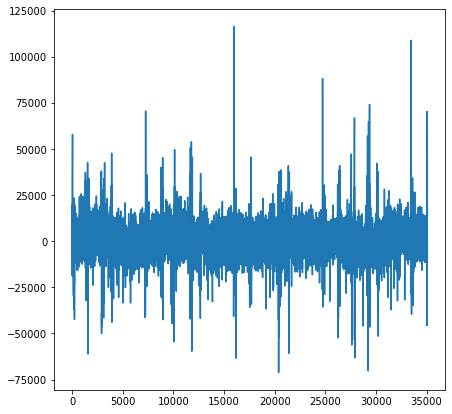

12


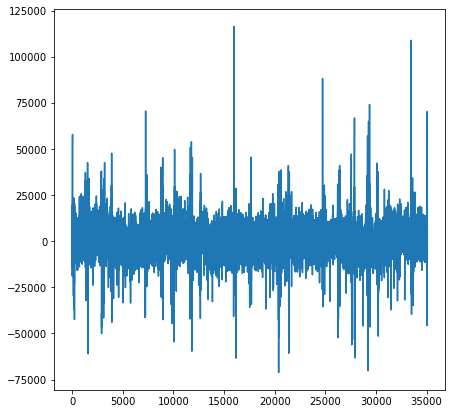

24


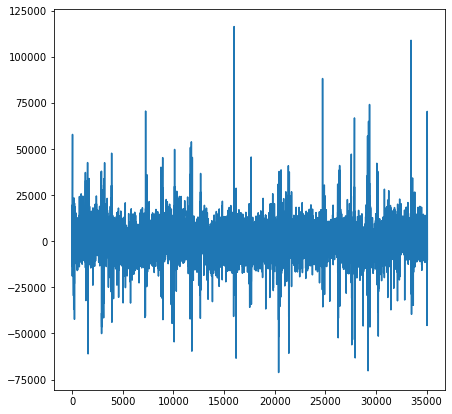

24*7*4


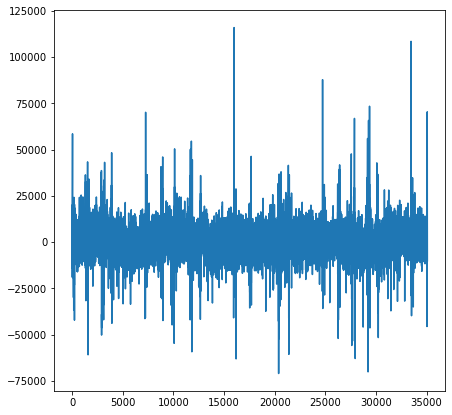

24*365//4


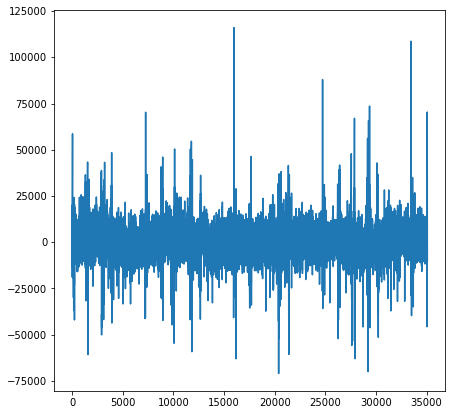

24*365//2


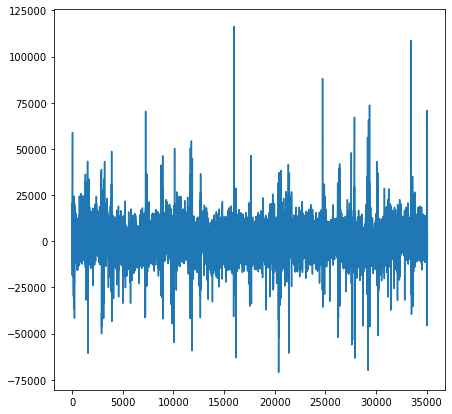

24*365


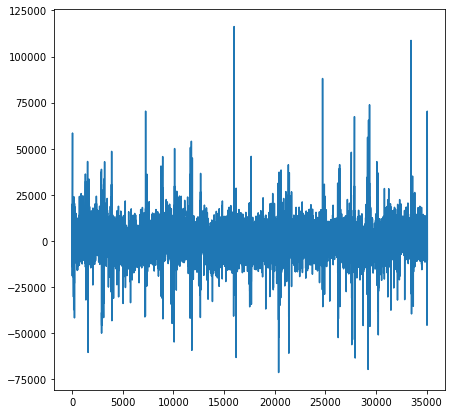

12


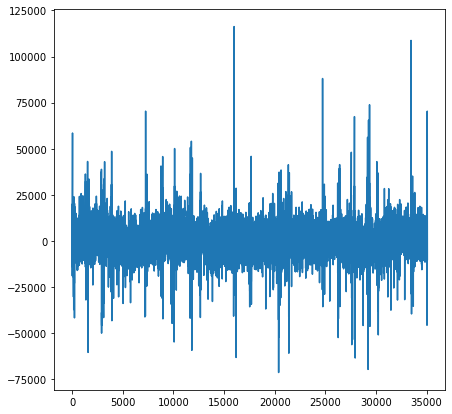

24


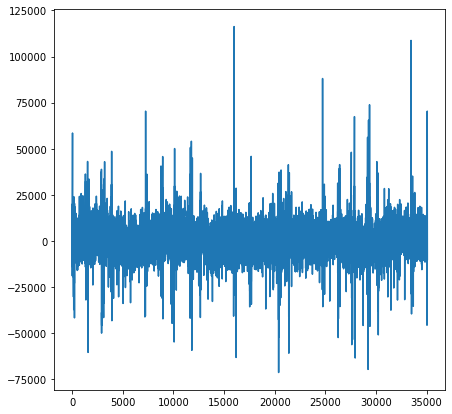

24*7*4


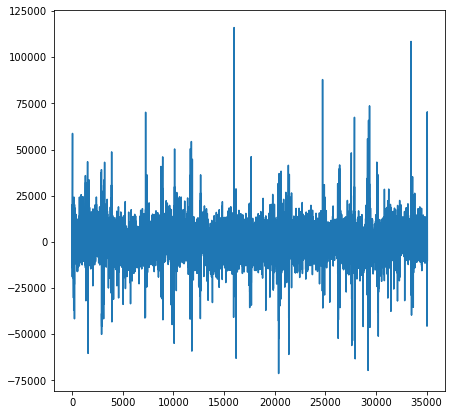

24*365//4


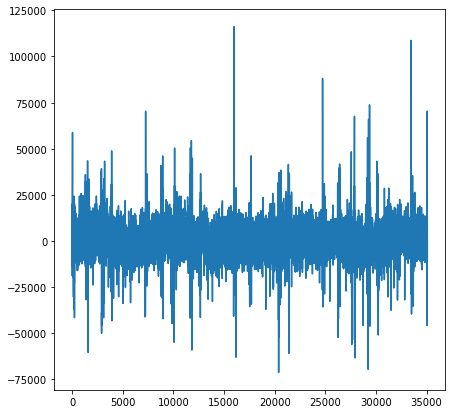

24*365//2


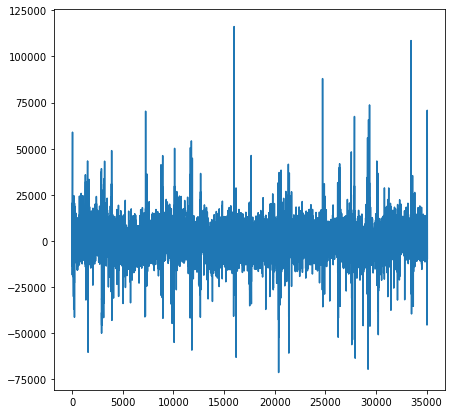

24*365


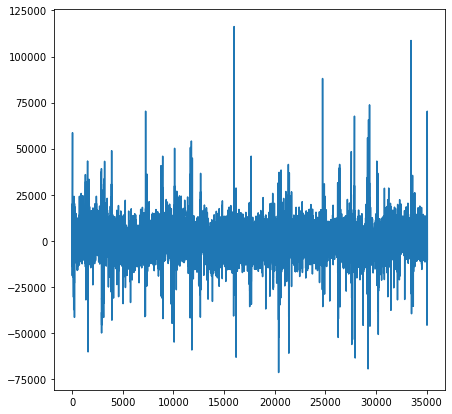

12


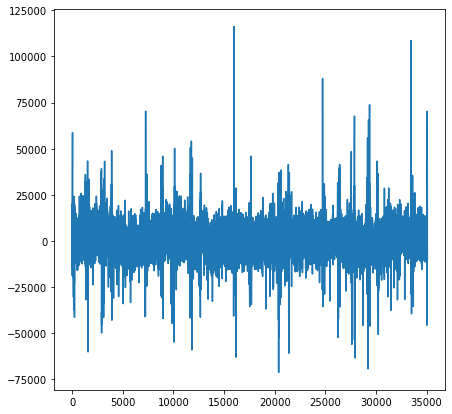

24


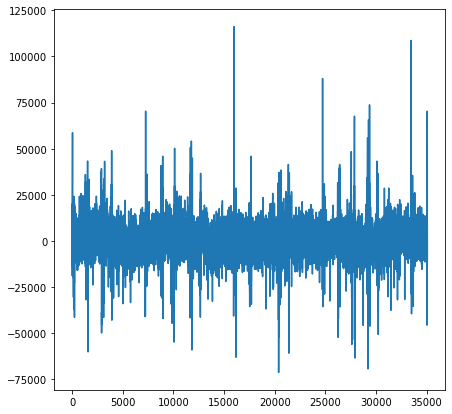

24*7*4


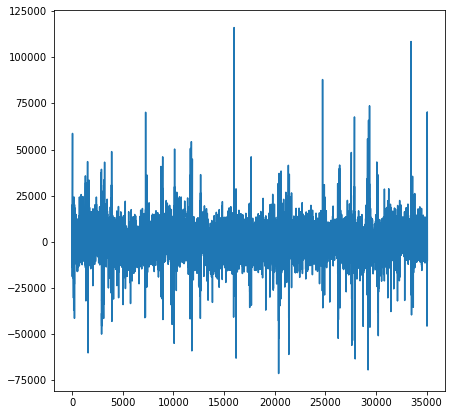

24*365//4


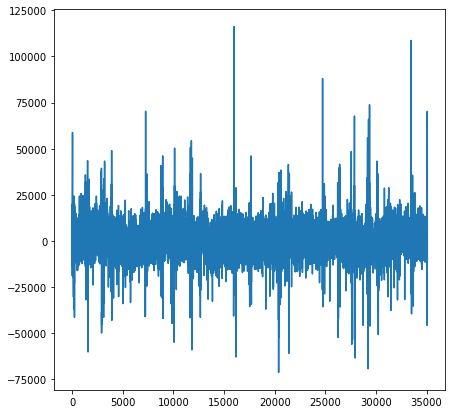

24*365//2


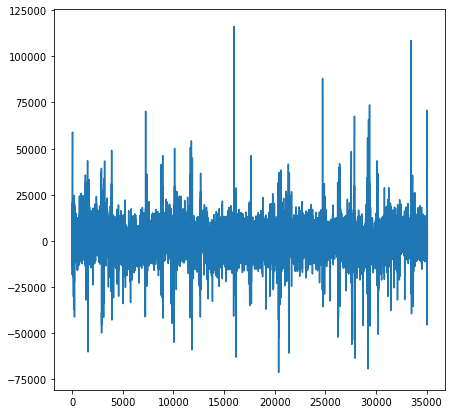

24*365


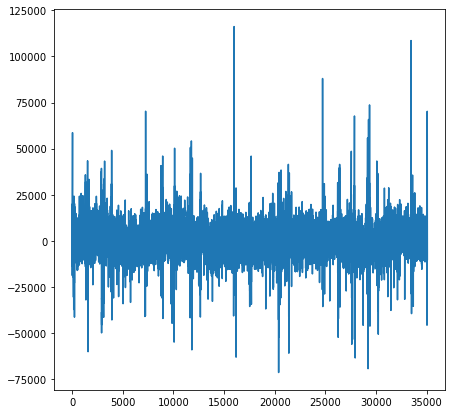

12


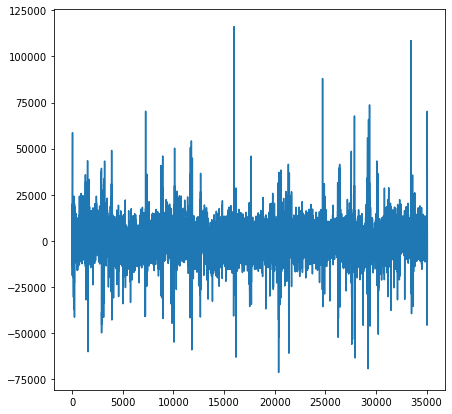

24


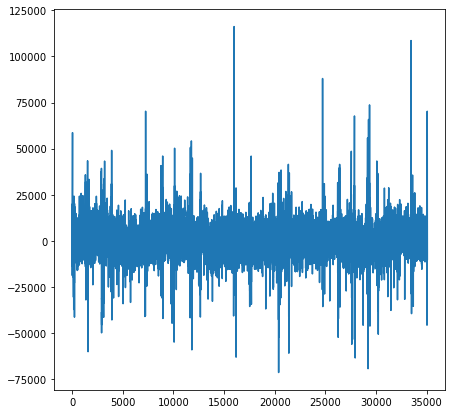

24*7*4


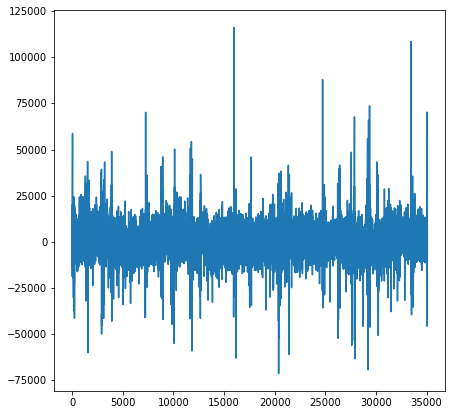

24*365//4


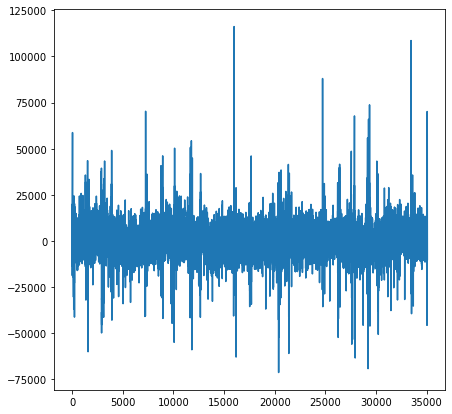

24*365//2


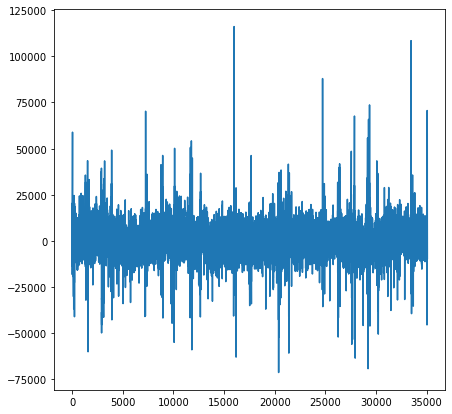

24*365


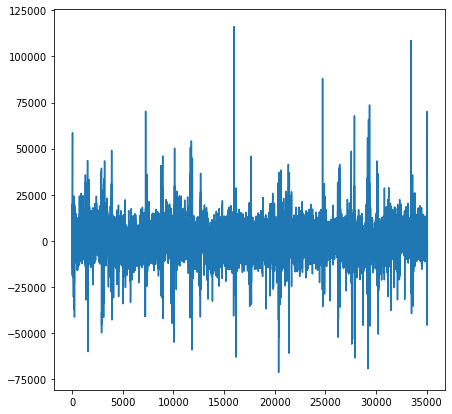

12


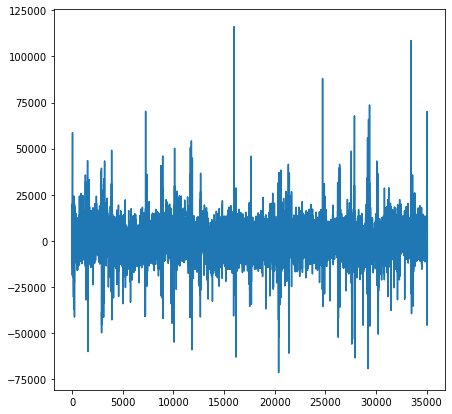

24


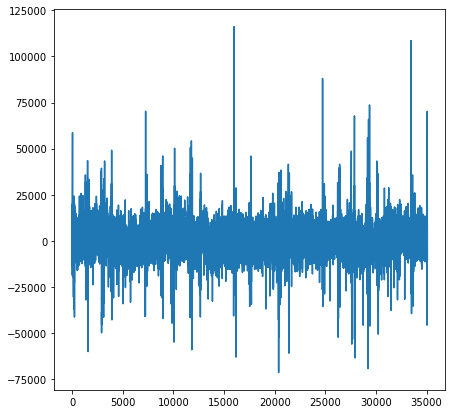

24*7*4


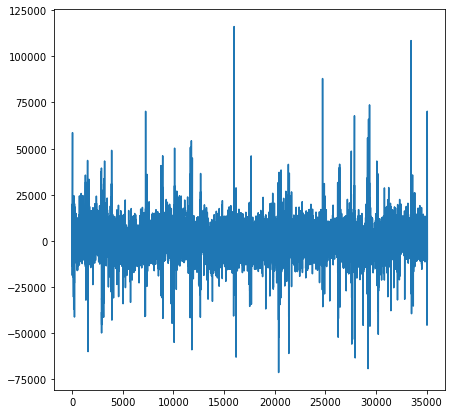

24*365//4


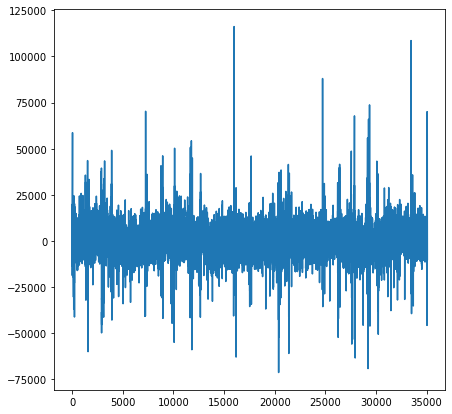

24*365//2


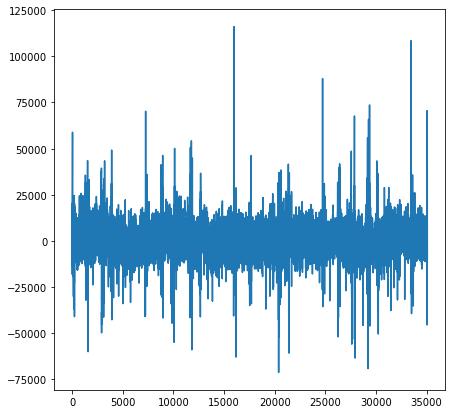

24*365


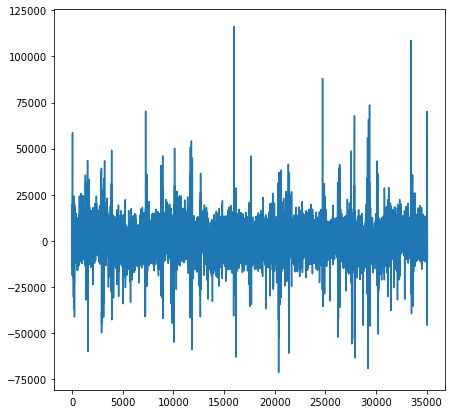

12


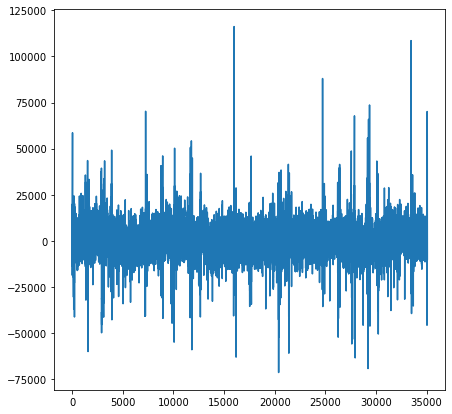

24


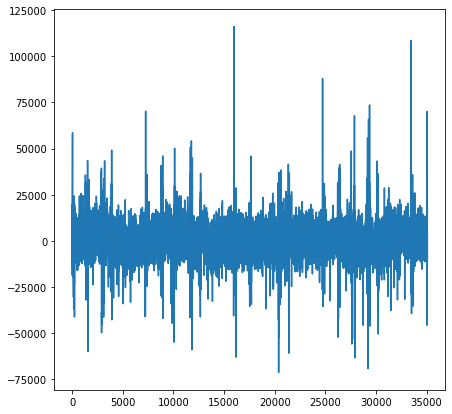

24*7*4


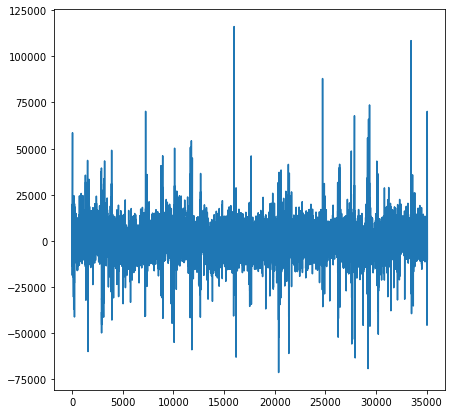

24*365//4


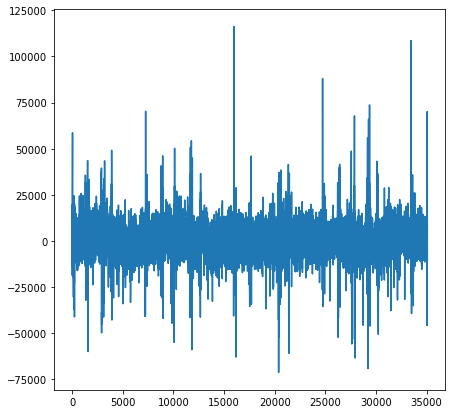

24*365//2


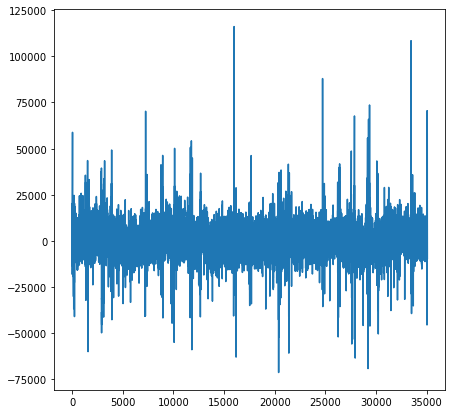

24*365


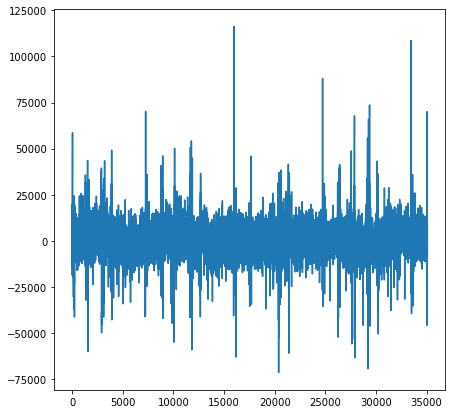

12


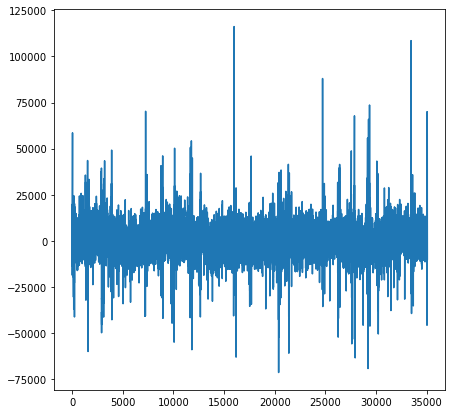

24


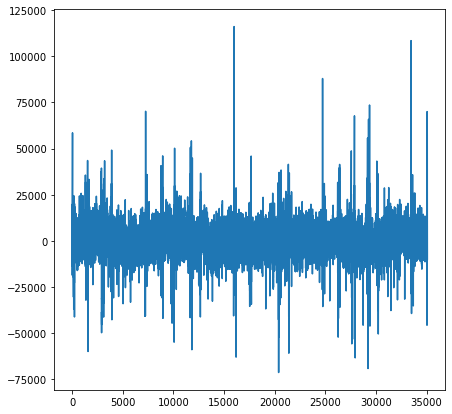

24*7*4


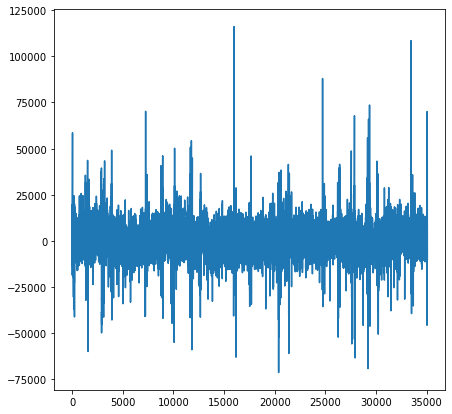

24*365//4


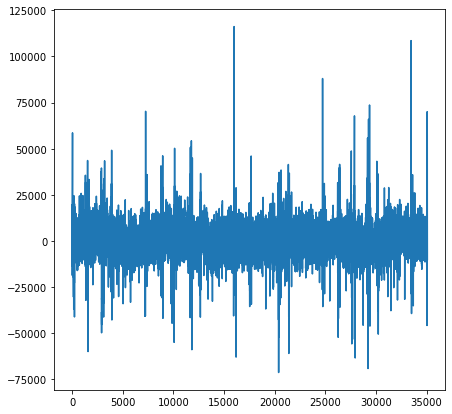

24*365//2


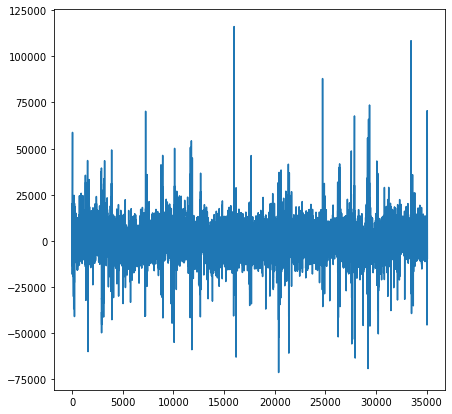

24*365


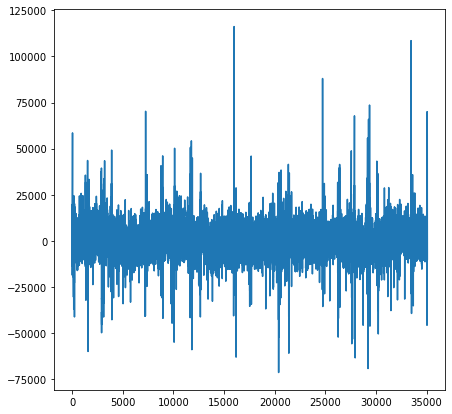

12


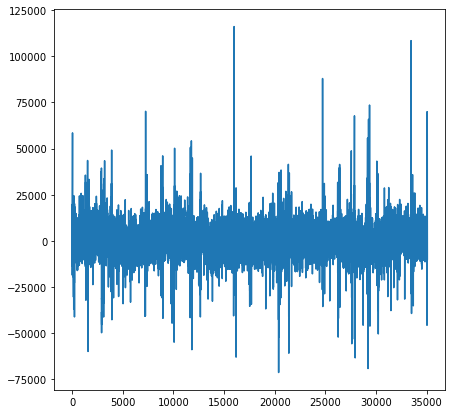

24


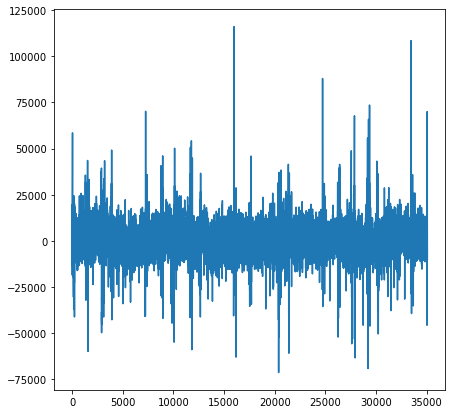

24*7*4


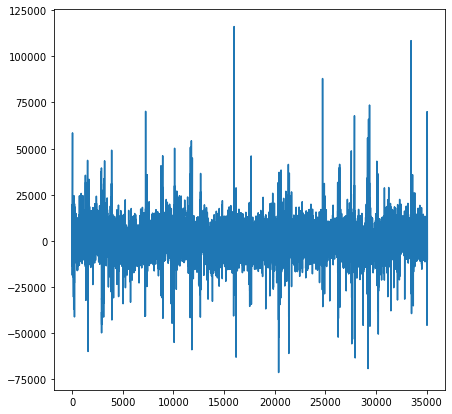

24*365//4


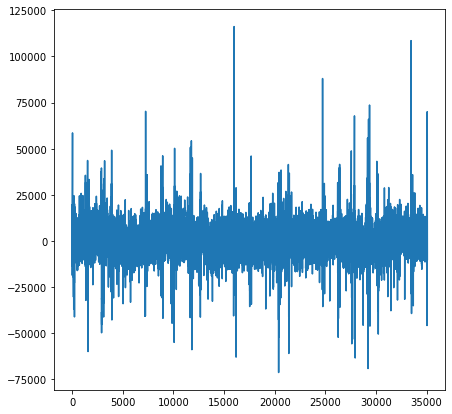

24*365//2


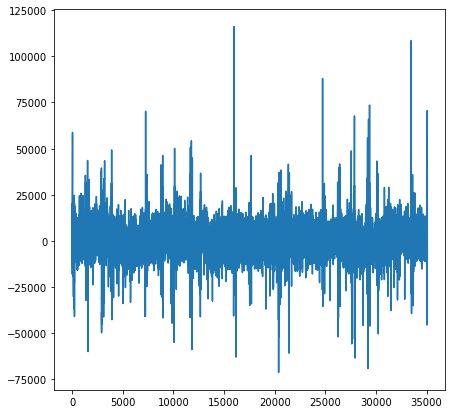

24*365


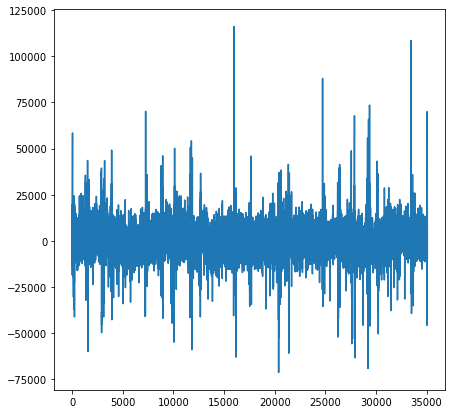

12


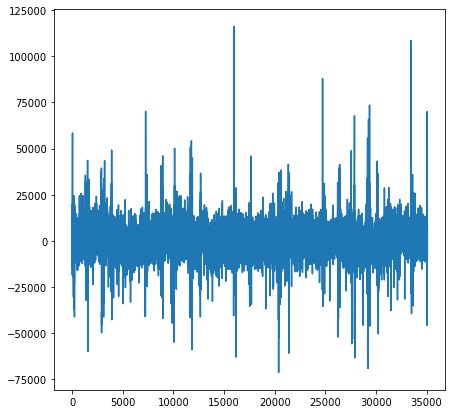

24


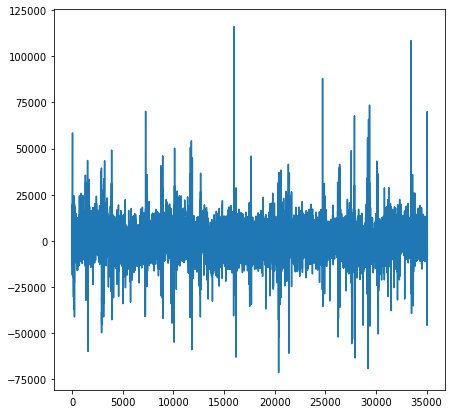

24*7*4


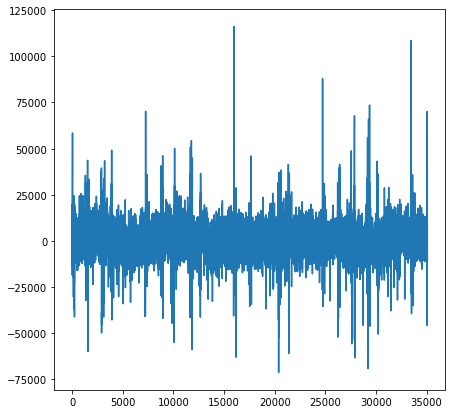

24*365//4


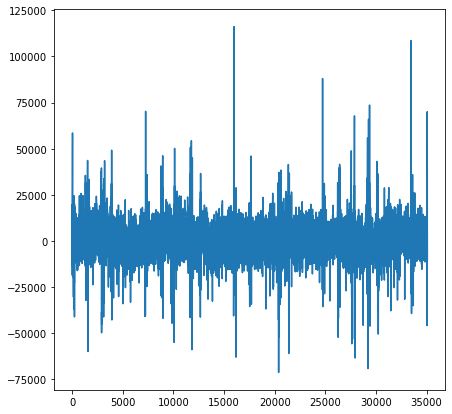

24*365//2


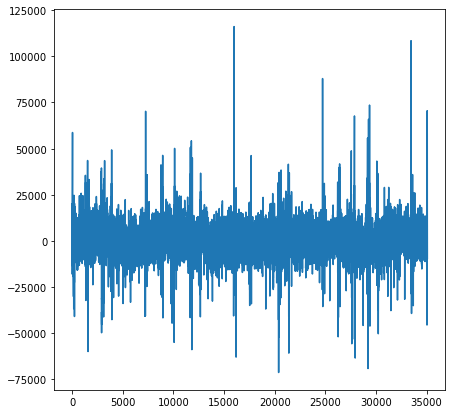

24*365


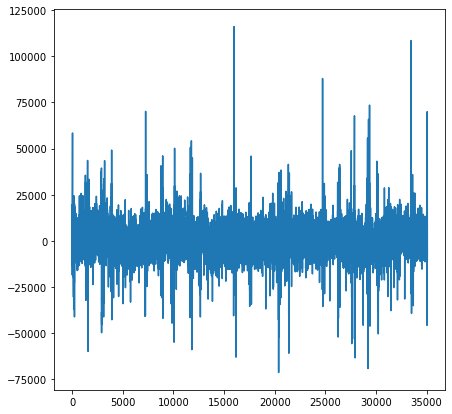

12


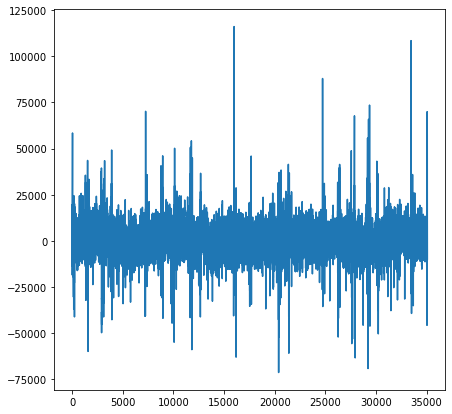

24


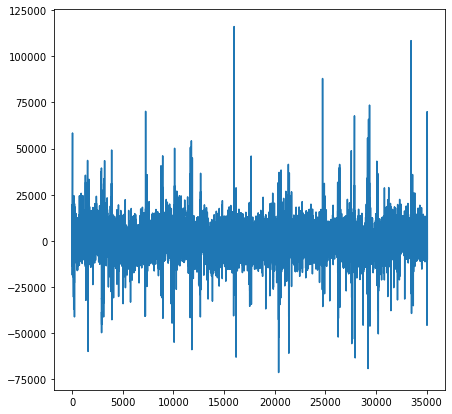

24*7*4


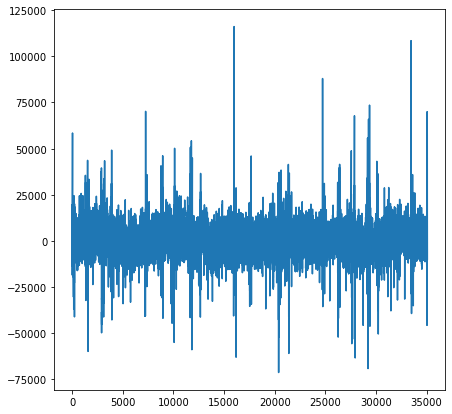

24*365//4


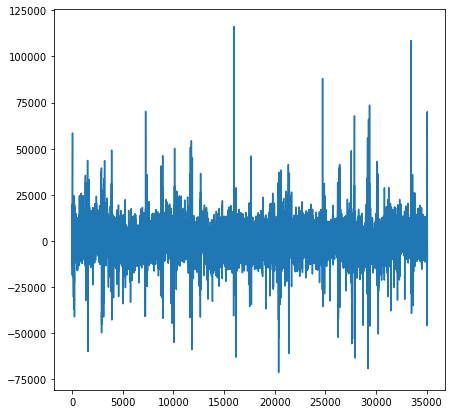

24*365//2


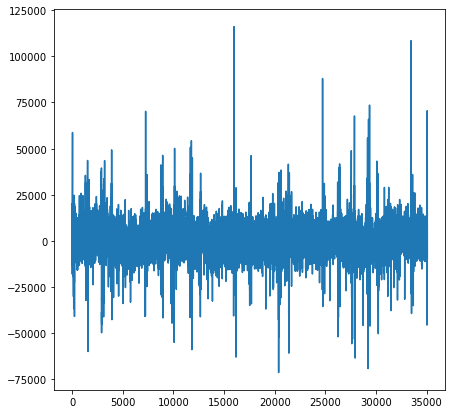

24*365


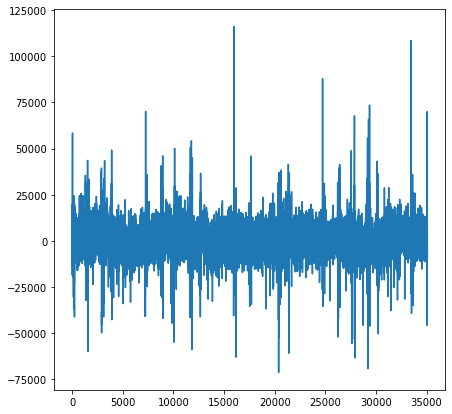

12


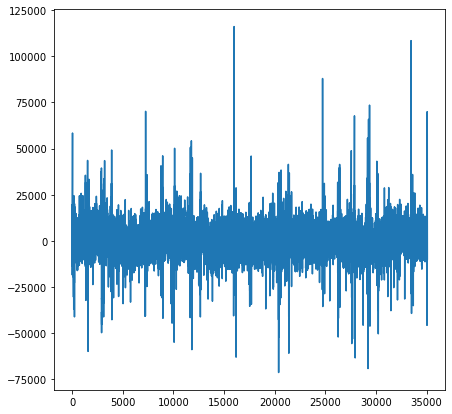

24


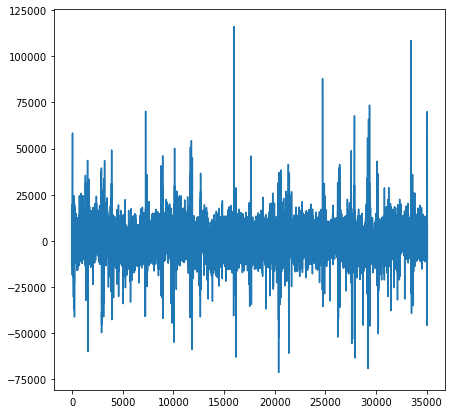

24*7*4


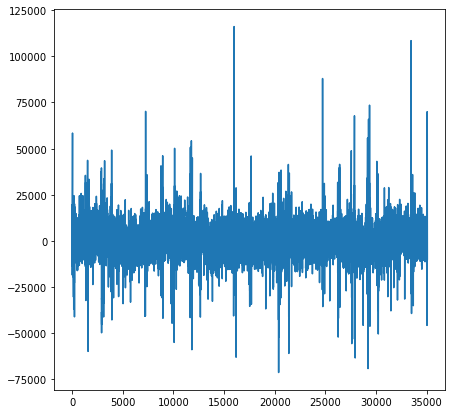

24*365//4


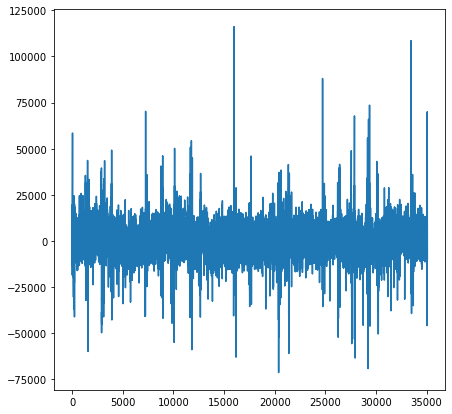

24*365//2


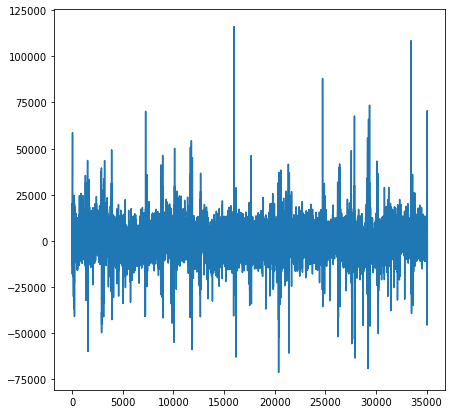

24*365


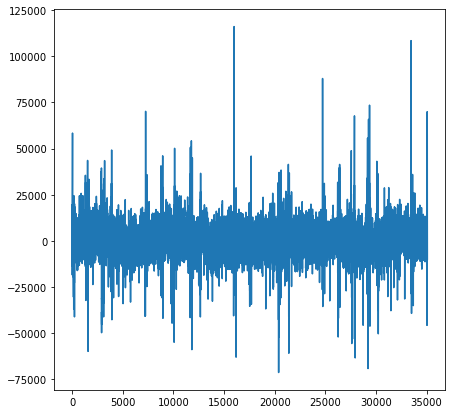

12


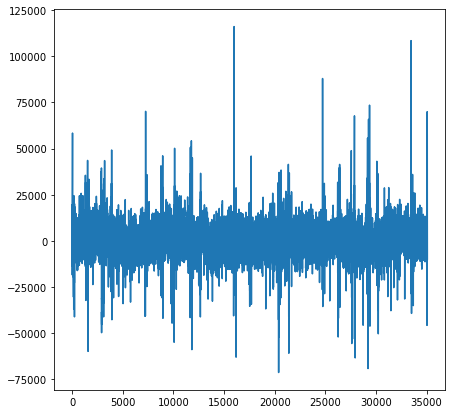

24


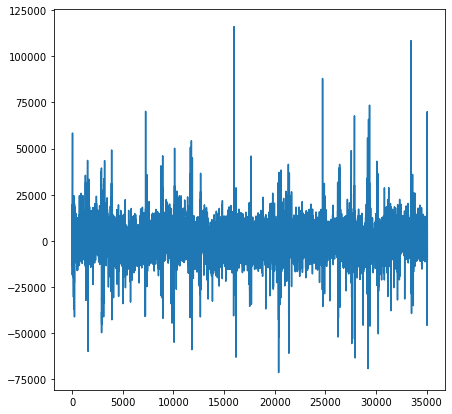

24*7*4


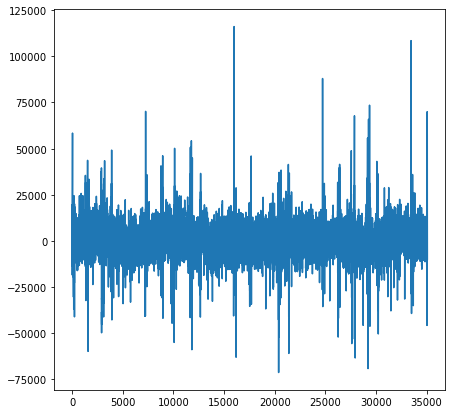

24*365//4


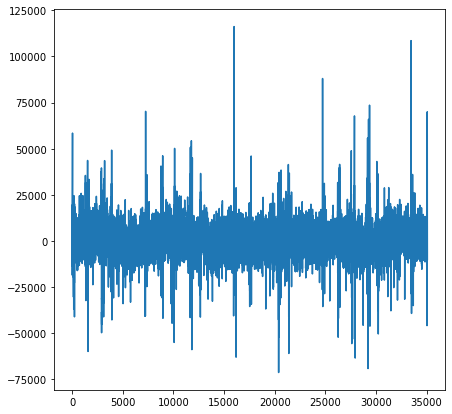

24*365//2


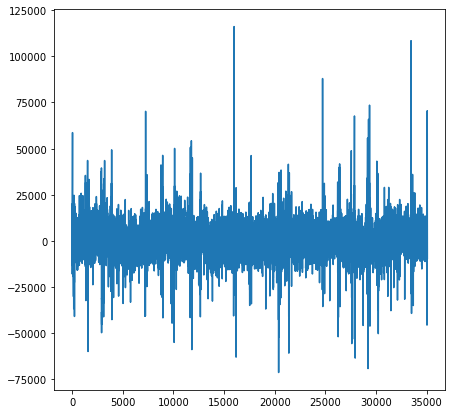

24*365


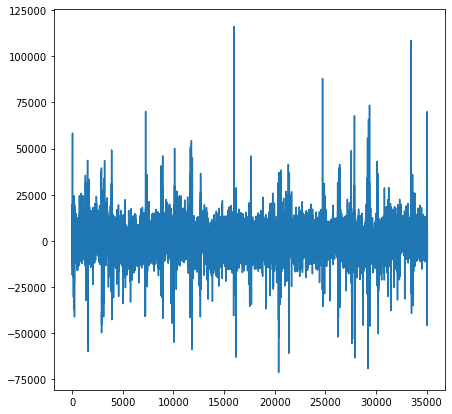

12


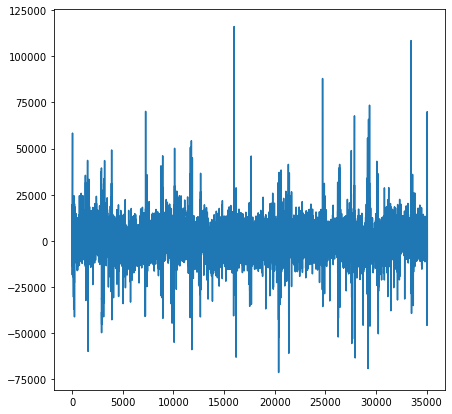

24


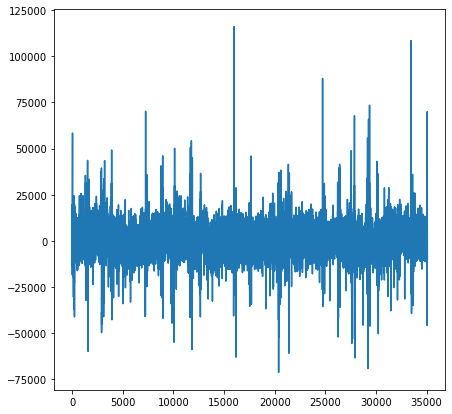

24*7*4


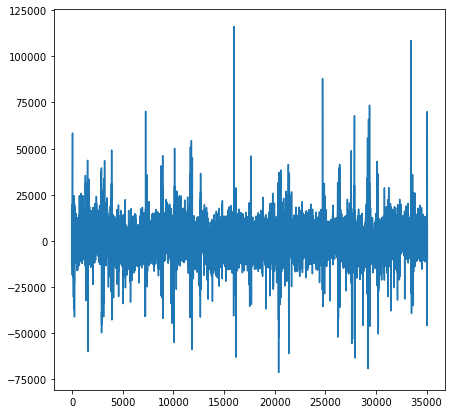

24*365//4


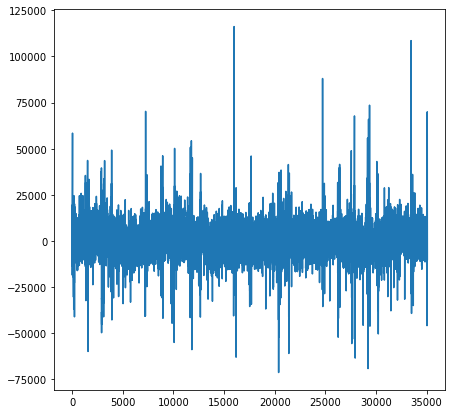

24*365//2


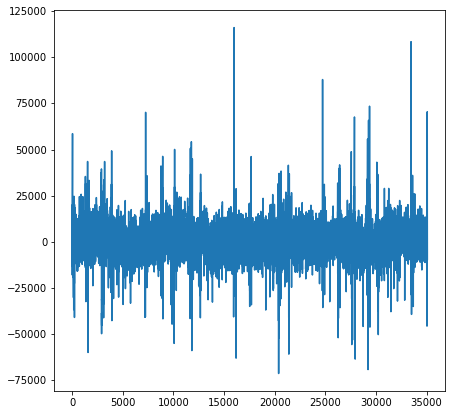

24*365


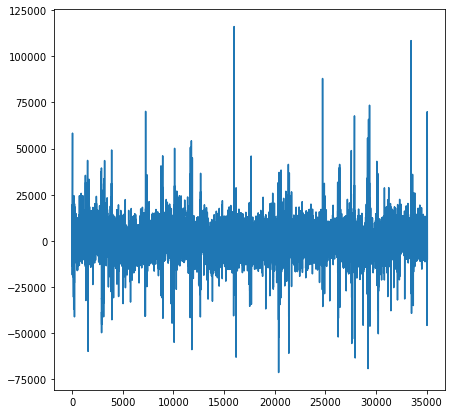

12


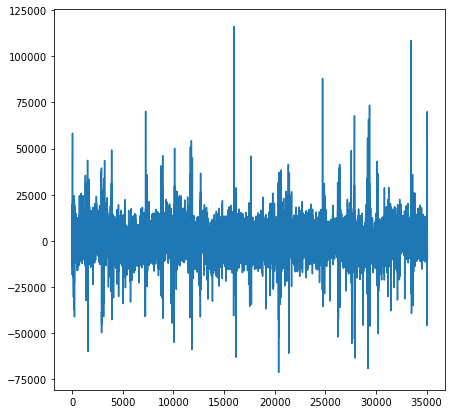

24


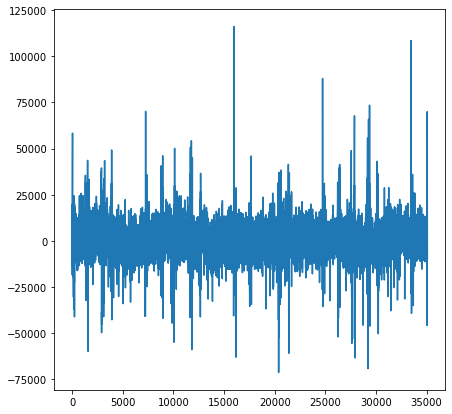

24*7*4


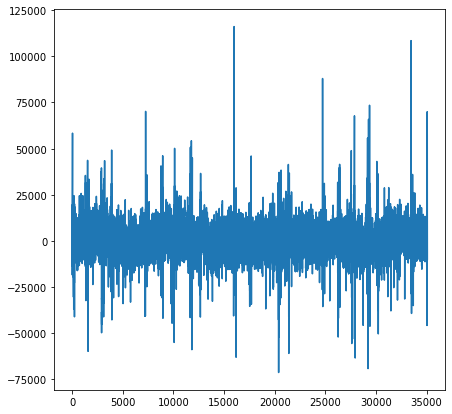

24*365//4


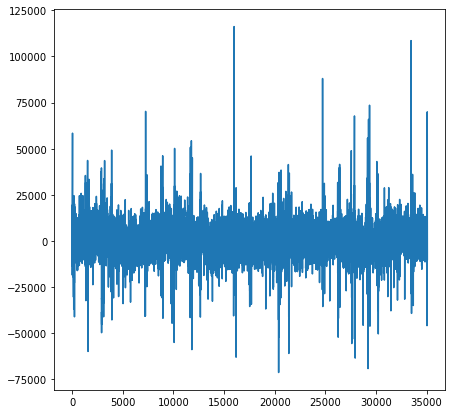

24*365//2


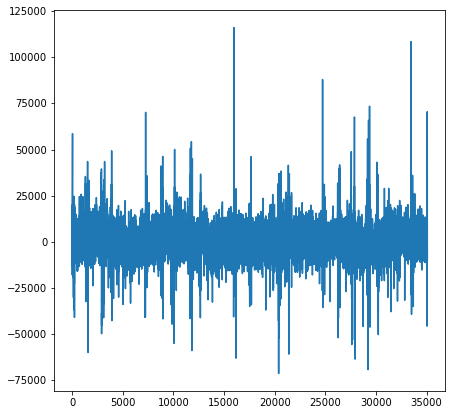

24*365


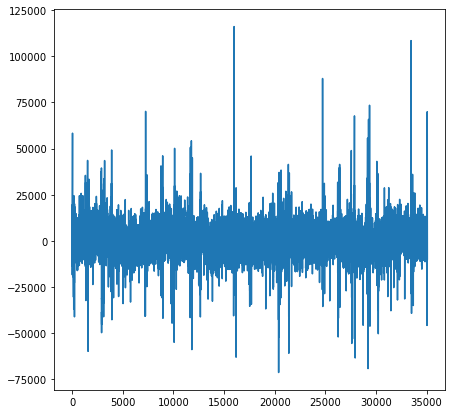

12


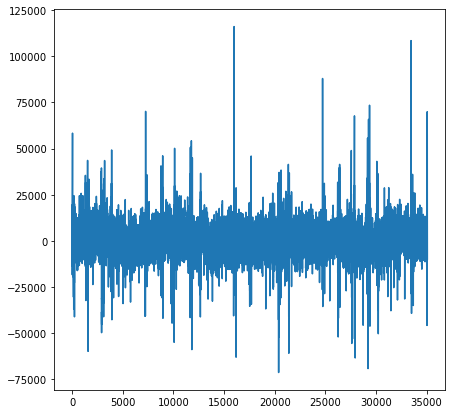

24


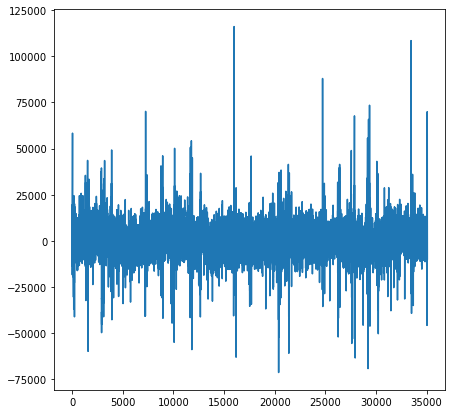

24*7*4


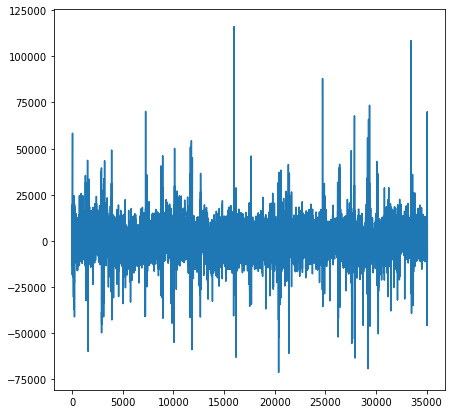

24*365//4


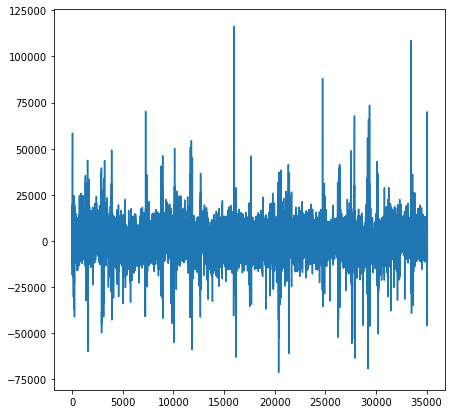

24*365//2


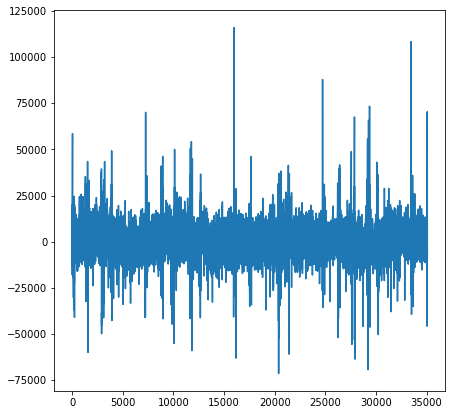

24*365


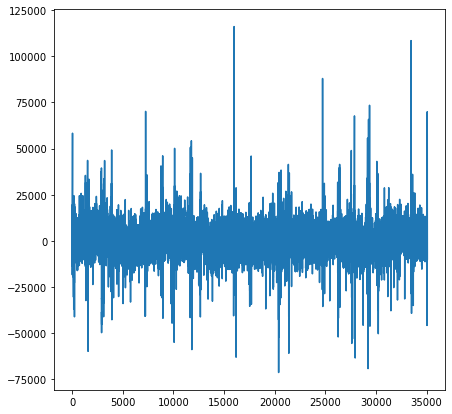

12


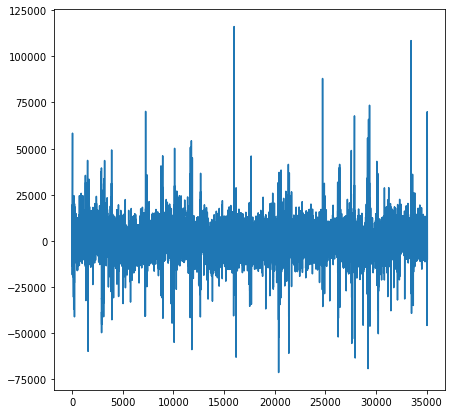

24


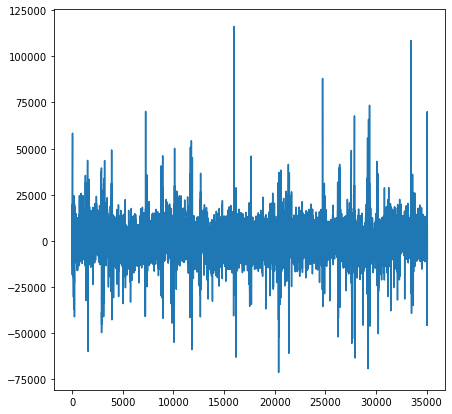

24*7*4


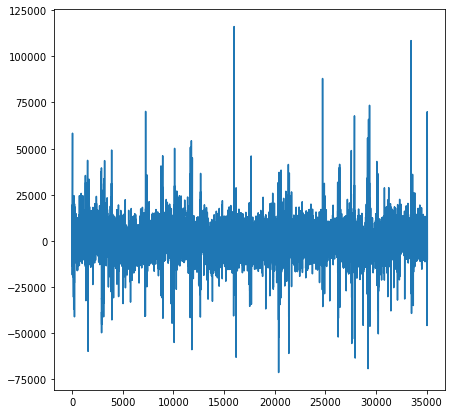

24*365//4


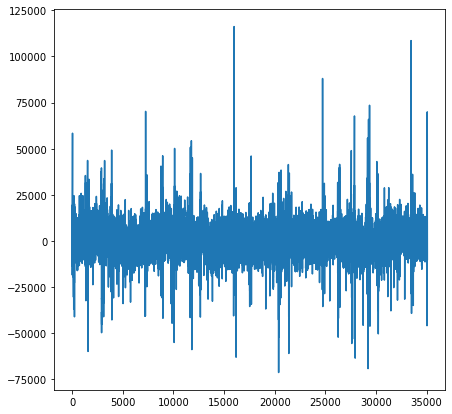

24*365//2


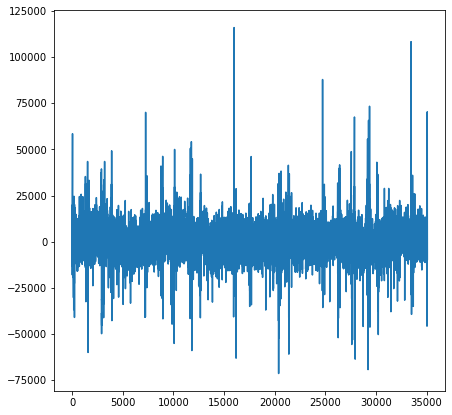

24*365


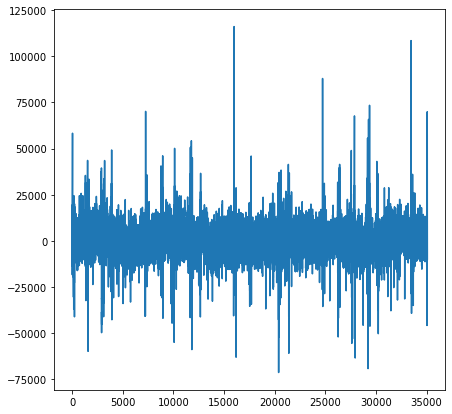

12


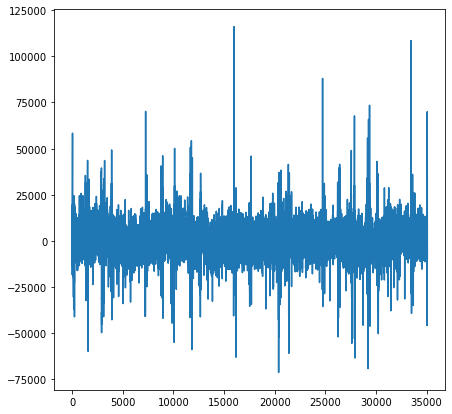

24


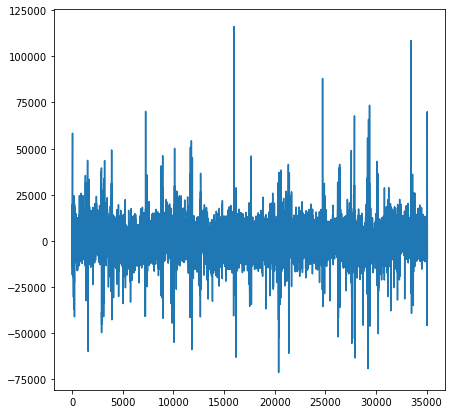

24*7*4


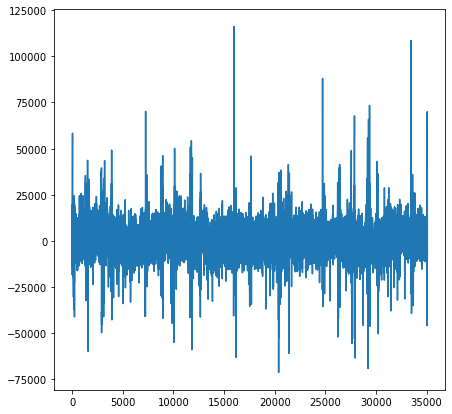

24*365//4


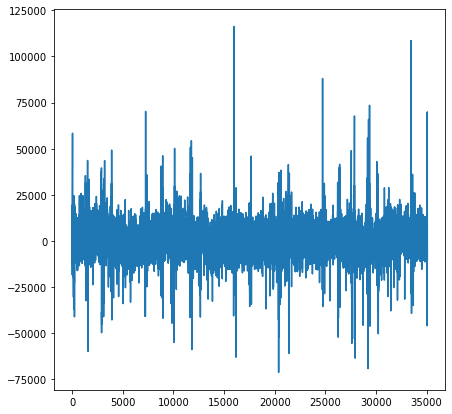

24*365//2


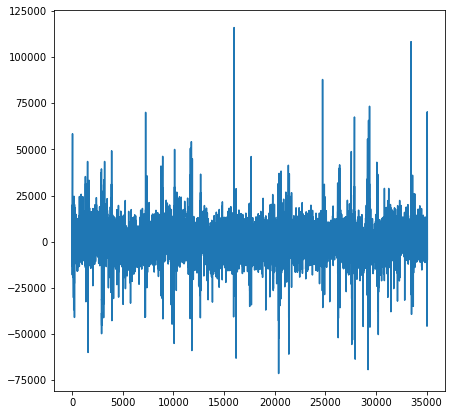

In [21]:
values = train["total"]
periods = ["24*365", "12", "24", "24*7*4", "24*365//4", "24*365//2"]
old_seasonals = {n: [] for n in periods}
for period in periods*20:# + periods[::-1] + periods:
    print(period)
    decomposed = my_decompose(values, period)

    # plt.plot(decomposed.seasonal[:eval(period)])
    # plt.show()

    values -= decomposed.seasonal
    old_seasonals[period].append(decomposed.seasonal)

    plt.plot(values)
    plt.show()

seasonals = dict()
for period, seasonal in old_seasonals.items():
    period = eval(period)
    seasonal = np.sum(seasonal, axis=0)

    sections = np.split(seasonal, range(period, len(seasonal) - len(seasonal)%period, period))
    if len(sections[-1]) != period:
        del sections[-1]
    seasonals[period] = np.mean(sections, axis=0)

8760


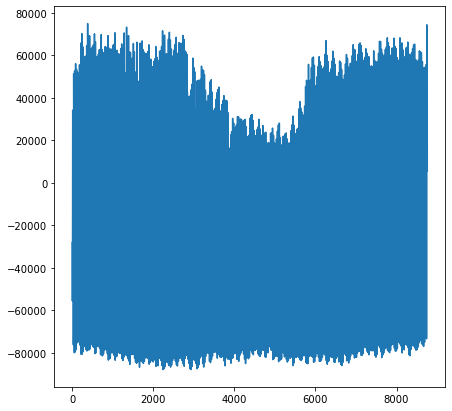

12


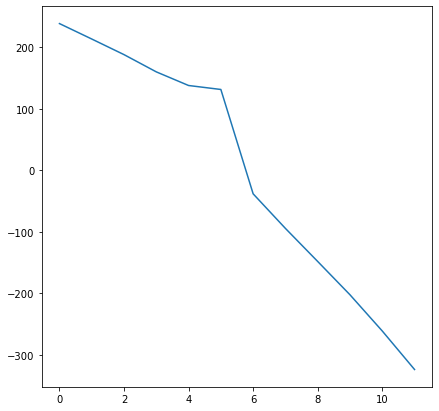

24


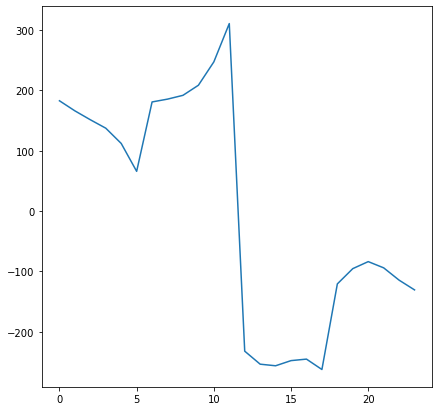

672


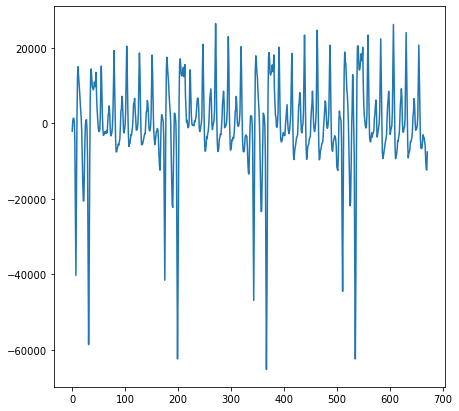

2190


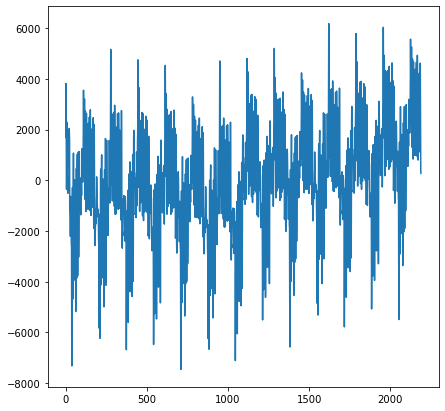

4380


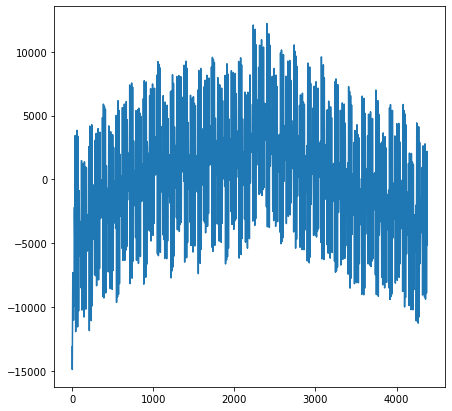

In [22]:
for period, seasonal in seasonals.items():
    print(period)
    plt.plot(seasonal)
    plt.show()

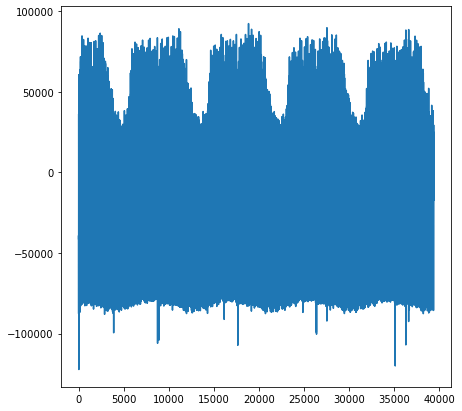

In [23]:
# for period, seasonal in seasonals.items():
#     seasonals = {period: seasonal}
#     if period < 1000:
#         break
# for period, seasonal in seasonals.items():
#     plt.plot(seasonal)
#     plt.show()
#     break


# to_predict = 4344
# neened_len = len(train) + to_predict

# lcm = 1
# for x in seasonals.values():
#     lcm = np.lcm(lcm, len(x))

# if lcm < neened_len:
#     lcm *= np.ceil(neened_len/lcm)
# lcm = int(lcm)

# extended = np.zeros(lcm)
# for period, seasonal in seasonals.items():
#     extended += np.repeat(seasonal, lcm//len(seasonal))

to_predict = 4344
neened_len = len(train) + to_predict

extended = np.zeros(neened_len)
for period, seasonal in seasonals.items():
    extended += np.tile(seasonal, int(np.ceil(neened_len/len(seasonal))))[:neened_len]

plt.plot(extended)
plt.show()

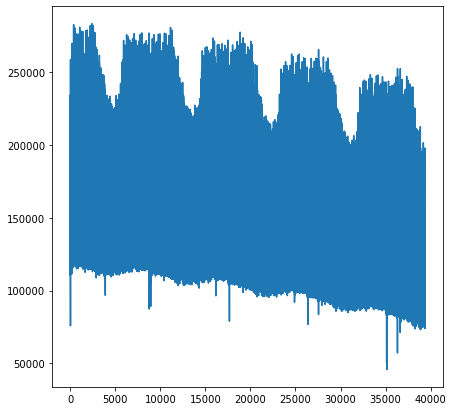

In [24]:
extended += func(np.arange(neened_len), *popt)
extended += global_trend_shift

plt.plot(extended)
plt.show()

In [25]:
# 01.01.2009 00:00:00 по 30.06.2009 23:00:00

last = train["datetime"][len(train)-1]
for _ in range(to_predict):
    last += dt.timedelta(hours=1)
    train.loc[train.shape[0]] = [last] + [pd.NA]*(len(train.columns)-1)
train[-to_predict+1:]



,datetime,total
35065,2009-01-01 01:00:00,NaN
35066,2009-01-01 02:00:00,NaN
35067,2009-01-01 03:00:00,NaN
35068,2009-01-01 04:00:00,NaN
35069,2009-01-01 05:00:00,NaN
...,...,...
39403,2009-06-30 19:00:00,NaN
39404,2009-06-30 20:00:00,NaN
39405,2009-06-30 21:00:00,NaN
39406,2009-06-30 22:00:00,NaN


In [26]:
train['datetime']

0       2005-01-01 00:00:00
1       2005-01-01 01:00:00
2       2005-01-01 02:00:00
3       2005-01-01 03:00:00
4       2005-01-01 04:00:00
                ...        
39403   2009-06-30 19:00:00
39404   2009-06-30 20:00:00
39405   2009-06-30 21:00:00
39406   2009-06-30 22:00:00
39407   2009-06-30 23:00:00
Name: datetime, Length: 39408, dtype: datetime64[ns]

In [27]:
holidays = pd.read_csv("holidays.csv")

In [28]:
train[['data', 'time']]= train["datetime"].astype(str).str.split(' ', expand=True)

In [29]:
train["data"] = pd.to_datetime(train["data"], format ="%Y-%m-%d")
train['isHoliday'] = train['data'].dt.date.astype('datetime64').isin(holidays['Date'])
train['isHoliday'] = train['isHoliday'].astype(int)
train.to_csv('out.csv')

In [30]:
del train['data']
del train['time']

In [31]:
train['datetime']

0       2005-01-01 00:00:00
1       2005-01-01 01:00:00
2       2005-01-01 02:00:00
3       2005-01-01 03:00:00
4       2005-01-01 04:00:00
                ...        
39403   2009-06-30 19:00:00
39404   2009-06-30 20:00:00
39405   2009-06-30 21:00:00
39406   2009-06-30 22:00:00
39407   2009-06-30 23:00:00
Name: datetime, Length: 39408, dtype: datetime64[ns]

In [32]:
train["year"] = [date.year for date in train["datetime"]]
train["season"] = [date.month % 4 for date in train["datetime"]]
train["month"] = [date.month for date in train["datetime"]]
train["week_of_year"] = [date.isocalendar()[1] for date in train["datetime"]]
# train["week_of_month"] = [(date.day + date.replace(day=1).weekday() - 1)//7 for date in train["datetime"]]
train["is_weekend"] = [int(date.weekday() >= 5) for date in train["datetime"]]
train["weekday"] = [date.weekday() for date in train["datetime"]]
train["hour"] = [date.hour for date in train["datetime"]]
train["holiday"] = out['isHoliday']

In [33]:
set([date.year for date in train["datetime"]])

{2005, 2006, 2007, 2008, 2009}

In [34]:
train["year"] -= 2005
train["year"] /= 4  # so 2009 would work

train["season"] /= 3

train["month"] -= 1
train["month"] /= 11

train["week_of_year"] -= 1
train["week_of_year"] /= 51

# train["week_of_month"] /= 4

train["weekday"] /= 6

train["hour"] /= 23

In [35]:
ind = len(train)-to_predict
X_submit = pd.DataFrame(train[ind:].values, columns=train.columns)
train.drop(train[ind:].index, inplace=True)
del X_submit["total"]
del X_submit["datetime"]
for column in X_submit.columns:
    X_submit[column] = X_submit[column].astype(np.float64)
X_submit

,isHoliday,year,season,month,week_of_year,is_weekend,weekday,hour,holiday
0,1.0,1.0,0.333333,0.000000,0.000000,0.0,0.500000,0.000000,1.0
1,1.0,1.0,0.333333,0.000000,0.000000,0.0,0.500000,0.043478,1.0
2,1.0,1.0,0.333333,0.000000,0.000000,0.0,0.500000,0.086957,1.0
3,1.0,1.0,0.333333,0.000000,0.000000,0.0,0.500000,0.130435,1.0
4,1.0,1.0,0.333333,0.000000,0.000000,0.0,0.500000,0.173913,1.0
...,...,...,...,...,...,...,...,...,...
4339,0.0,1.0,0.666667,0.454545,0.509804,0.0,0.166667,0.826087,0.0
4340,0.0,1.0,0.666667,0.454545,0.509804,0.0,0.166667,0.869565,0.0
4341,0.0,1.0,0.666667,0.454545,0.509804,0.0,0.166667,0.913043,0.0
4342,0.0,1.0,0.666667,0.454545,0.509804,0.0,0.166667,0.956522,0.0


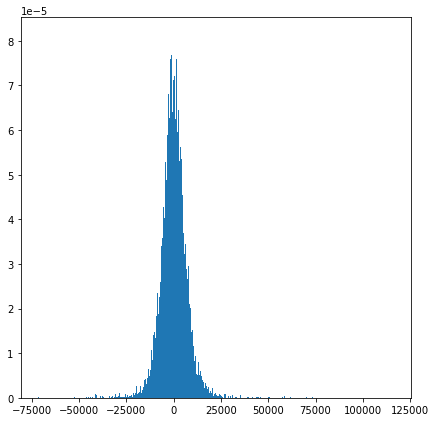

In [36]:
plt.hist(values, 1500, density=True)
plt.show()

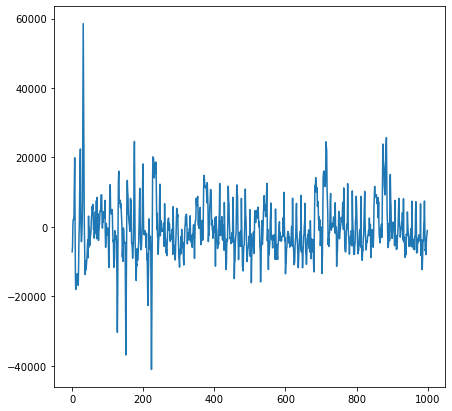

In [37]:
plt.plot(values[:1000])
plt.show()

[[ 0.00000000e+00 -5.94097658e+03]
 [ 1.00000000e+00 -5.85333785e+03]
 [ 2.00000000e+00 -5.76560844e+03]
 ...
 [ 3.50610000e+04  6.63856600e+03]
 [ 3.50620000e+04  6.69147936e+03]
 [ 3.50630000e+04  6.74474606e+03]]


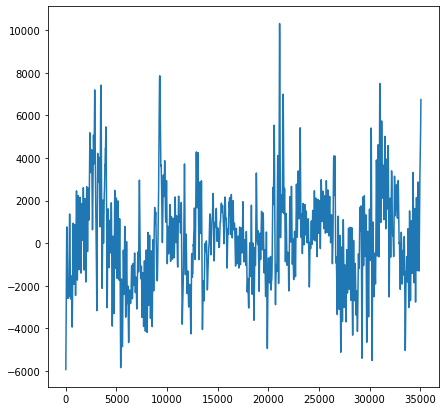

In [38]:
print(lowess(values, np.arange(len(values)), frac=0.004))
train["leftovers"] = values
train["smoothed_leftovers"] = lowess(values, np.arange(len(values)), frac=0.004)[:, 1]
plt.plot(train["smoothed_leftovers"])
plt.show()

In [39]:
train.sort_values(by=["season", "month", "is_weekend", "weekday", "hour", "week_of_year", "year"])

,datetime,total,isHoliday,year,season,month,week_of_year,is_weekend,weekday,hour,holiday,leftovers,smoothed_leftovers
2232,2005-04-04 00:00:00,-15613.136216,0,0.00,0.0,0.272727,0.254902,0,0.0,0.0,0,-290.669720,2548.991399
10968,2006-04-03 00:00:00,-15329.073002,0,0.25,0.0,0.272727,0.254902,0,0.0,0.0,0,-638.315563,832.563254
19704,2007-04-02 00:00:00,-7727.884703,0,0.50,0.0,0.272727,0.254902,0,0.0,0.0,0,6376.592542,-1930.914788
2400,2005-04-11 00:00:00,-18594.461080,0,0.00,0.0,0.272727,0.274510,0,0.0,0.0,0,563.879499,4636.404306
11136,2006-04-10 00:00:00,-18399.623687,0,0.25,0.0,0.272727,0.274510,0,0.0,0.0,0,-1206.759023,2192.161230
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7943,2005-11-27 23:00:00,26181.433790,0,0.00,1.0,0.909091,0.901961,1,1.0,1.0,0,-5525.051723,-325.526593
16679,2006-11-26 23:00:00,37200.285788,0,0.25,1.0,0.909091,0.901961,1,1.0,1.0,0,4479.629128,732.281592
25415,2007-11-25 23:00:00,33026.075514,0,0.50,1.0,0.909091,0.901961,1,1.0,1.0,0,1479.046661,1971.619376
34151,2008-11-23 23:00:00,33009.526695,0,0.75,1.0,0.909091,0.901961,1,1.0,1.0,0,-1911.385459,300.073691


In [40]:
train.describe()

,total,isHoliday,year,season,month,week_of_year,is_weekend,weekday,hour,holiday,leftovers,smoothed_leftovers
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,182.310707,0.035592,0.375257,0.498745,0.502085,0.499685,0.286105,0.499886,0.500000,0.035592,193.320584,202.099990
std,44510.593192,0.185273,0.279589,0.373802,0.313523,0.295280,0.451946,0.333538,0.300969,0.185273,7421.714591,2144.047932
min,-98843.734361,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-71469.103008,-5940.976581
25%,-27666.754693,0.000000,0.250000,0.000000,0.272727,0.235294,0.000000,0.166667,0.250000,0.000000,-3639.665957,-1218.324145
50%,11630.643215,0.000000,0.500000,0.333333,0.545455,0.490196,0.000000,0.500000,0.500000,0.000000,81.964959,168.420045
75%,32287.640240,0.000000,0.750000,1.000000,0.818182,0.764706,1.000000,0.833333,0.750000,0.000000,4091.869823,1472.116609
max,105232.374088,1.000000,0.750000,1.000000,1.000000,1.019608,1.000000,1.000000,1.000000,1.000000,116109.399134,10314.763883


In [41]:
train.corr()

,total,isHoliday,year,season,month,week_of_year,is_weekend,weekday,hour,holiday,leftovers,smoothed_leftovers
total,1.000000,-2.723459e-02,-1.089026e-03,-7.532143e-03,-5.140984e-03,-8.783932e-03,-1.723379e-02,-2.036569e-02,6.897887e-01,-2.723459e-02,0.163033,0.028412
isHoliday,-0.027235,1.000000e+00,6.430556e-03,6.449144e-04,-1.512510e-01,-1.599932e-01,-6.439470e-02,-7.747008e-02,-1.685776e-19,1.000000e+00,-0.065406,-0.000271
year,-0.001089,6.430556e-03,1.000000e+00,4.124187e-04,-1.204013e-03,-5.821027e-03,-3.289666e-03,-3.210946e-03,-1.881437e-20,6.430556e-03,-0.005666,0.044454
season,-0.007532,6.449144e-04,4.124187e-04,1.000000e+00,-6.780733e-02,-5.912926e-02,-1.926463e-03,1.676365e-03,5.087171e-17,6.449144e-04,-0.000076,-0.010950
month,-0.005141,-1.512510e-01,-1.204013e-03,-6.780733e-02,1.000000e+00,9.701007e-01,4.134813e-03,5.804036e-03,1.181171e-17,-1.512510e-01,0.006426,0.012841
week_of_year,-0.008784,-1.599932e-01,-5.821027e-03,-5.912926e-02,9.701007e-01,1.000000e+00,6.006435e-03,6.484008e-03,-2.039769e-18,-1.599932e-01,-0.000655,-0.010560
is_weekend,-0.017234,-6.439470e-02,-3.289666e-03,-1.926463e-03,4.134813e-03,6.006435e-03,1.000000e+00,7.910701e-01,-1.163920e-20,-6.439470e-02,-0.000161,0.010199
weekday,-0.020366,-7.747008e-02,-3.210946e-03,1.676365e-03,5.804036e-03,6.484008e-03,7.910701e-01,1.000000e+00,1.315712e-17,-7.747008e-02,-0.000124,-0.006281
hour,0.689789,-1.685776e-19,-1.881437e-20,5.087171e-17,1.181171e-17,-2.039769e-18,-1.163920e-20,1.315712e-17,1.000000e+00,-1.685776e-19,0.000040,0.001210
holiday,-0.027235,1.000000e+00,6.430556e-03,6.449144e-04,-1.512510e-01,-1.599932e-01,-6.439470e-02,-7.747008e-02,-1.685776e-19,1.000000e+00,-0.065406,-0.000271


In [42]:
# plt.plot(train["season"])
# plt.plot(train["month"])
# plt.plot(train["is_weekend"][:24*7*2])
# plt.plot(train["weekday"][:24*7*2])
# plt.plot(train["hour"][:24*3])

In [43]:
feature_columns = []

numeric_year = tf.feature_column.numeric_column("year")
year = bucketize_column(numeric_year, -0.1, 1.1, 5+1)
feature_columns.append(year)

numeric_season = tf.feature_column.numeric_column("season")
season = bucketize_column(numeric_season, -0.1, 1.1, 4+1)
feature_columns.append(season)

numeric_month = tf.feature_column.numeric_column("month")
month = bucketize_column(numeric_month, -0.1, 1.1, 12+1)
feature_columns.append(month)

numeric_week_of_year = tf.feature_column.numeric_column("week_of_year")
week_of_year = bucketize_column(numeric_week_of_year, -0.1, 1.1, 52+1)
feature_columns.append(week_of_year)

numeric_is_weekend = tf.feature_column.numeric_column("is_weekend")
is_weekend = bucketize_column(numeric_is_weekend, -0.1, 1.1, 2+1)
feature_columns.append(is_weekend)

numeric_weekday = tf.feature_column.numeric_column("weekday")
weekday = bucketize_column(numeric_weekday, -0.1, 1.1, 7+1)
feature_columns.append(weekday)

numeric_hour = tf.feature_column.numeric_column("hour")
hour = bucketize_column(numeric_hour, -0.1, 1.1, 24+1)
feature_columns.append(hour)

season_x_weekday = tf.feature_column.crossed_column([season, weekday], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(season_x_weekday)
feature_columns.append(crossed_feature)

weekday_x_hour = tf.feature_column.crossed_column([weekday, hour], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(weekday_x_hour)
feature_columns.append(crossed_feature)

month_x_weekday = tf.feature_column.crossed_column([month, weekday], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(month_x_weekday)
feature_columns.append(crossed_feature)

Epoch 1/600
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
49/64 [=====================>........] - ETA: 0s - loss: 0.0693 - tf_error: 0.0693WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'isHoliday': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=int32>, 'year': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=float32>, 'season': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=float32>, 'month': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=float32>, 'week_of_year': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=float32>, 'is_weekend': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=int64>, 'weekday': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=float32>, 'hour': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float32>, 'holiday': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int64>}
Consider rewriting this model with t

Epoch 41/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0633 - tf_error: 0.0634 - val_loss: 0.1282 - val_tf_error: 0.2357
Epoch 42/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0666 - tf_error: 0.0666 - val_loss: 0.1282 - val_tf_error: 0.2356
Epoch 43/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0761 - tf_error: 0.0760 - val_loss: 0.1281 - val_tf_error: 0.2356
Epoch 44/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0588 - tf_error: 0.0587 - val_loss: 0.1281 - val_tf_error: 0.2356
Epoch 45/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0531 - tf_error: 0.0531 - val_loss: 0.1281 - val_tf_error: 0.2356
Epoch 46/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0673 - tf_error: 0.0674 - val_loss: 0.1281 - val_tf_error: 0.2355
Epoch 47/600
64/64 [==============================] - 0s 2ms/step - loss: 0.0715 - tf_error: 0.0715 - val_loss: 0.1280 - val_tf_error: 0.2355
Epoch 

Epoch 99/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0631 - tf_error: 0.0630 - val_loss: 0.1267 - val_tf_error: 0.2344
Epoch 100/600
64/64 [==============================] - 0s 2ms/step - loss: 0.0662 - tf_error: 0.0661 - val_loss: 0.1267 - val_tf_error: 0.2343
Epoch 101/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0605 - tf_error: 0.0606 - val_loss: 0.1267 - val_tf_error: 0.2343
Epoch 102/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0627 - tf_error: 0.0627 - val_loss: 0.1267 - val_tf_error: 0.2343
Epoch 103/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0575 - tf_error: 0.0575 - val_loss: 0.1266 - val_tf_error: 0.2343
Epoch 104/600
64/64 [==============================] - 0s 2ms/step - loss: 0.0541 - tf_error: 0.0541 - val_loss: 0.1266 - val_tf_error: 0.2343
Epoch 105/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0603 - tf_error: 0.0604 - val_loss: 0.1266 - val_tf_error: 0.2342


64/64 [==============================] - 0s 3ms/step - loss: 0.0706 - tf_error: 0.0705 - val_loss: 0.1255 - val_tf_error: 0.2332
Epoch 157/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0535 - tf_error: 0.0535 - val_loss: 0.1254 - val_tf_error: 0.2332
Epoch 158/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0650 - tf_error: 0.0651 - val_loss: 0.1254 - val_tf_error: 0.2332
Epoch 159/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0665 - tf_error: 0.0665 - val_loss: 0.1254 - val_tf_error: 0.2332
Epoch 160/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0701 - tf_error: 0.0701 - val_loss: 0.1254 - val_tf_error: 0.2332
Epoch 161/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0689 - tf_error: 0.0688 - val_loss: 0.1254 - val_tf_error: 0.2331
Epoch 162/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0578 - tf_error: 0.0579 - val_loss: 0.1253 - val_tf_error: 0.2331
Epoch 163/600

64/64 [==============================] - 0s 4ms/step - loss: 0.0587 - tf_error: 0.0587 - val_loss: 0.1239 - val_tf_error: 0.2319
Epoch 214/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0673 - tf_error: 0.0674 - val_loss: 0.1239 - val_tf_error: 0.2318
Epoch 215/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0582 - tf_error: 0.0581 - val_loss: 0.1238 - val_tf_error: 0.2318
Epoch 216/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0577 - tf_error: 0.0577 - val_loss: 0.1238 - val_tf_error: 0.2318
Epoch 217/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0596 - tf_error: 0.0597 - val_loss: 0.1238 - val_tf_error: 0.2318
Epoch 218/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0629 - tf_error: 0.0629 - val_loss: 0.1238 - val_tf_error: 0.2317
Epoch 219/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0632 - tf_error: 0.0631 - val_loss: 0.1237 - val_tf_error: 0.2317
Epoch 220/600

64/64 [==============================] - 0s 3ms/step - loss: 0.0508 - tf_error: 0.0509 - val_loss: 0.1221 - val_tf_error: 0.2303
Epoch 271/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0561 - tf_error: 0.0563 - val_loss: 0.1221 - val_tf_error: 0.2303
Epoch 272/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0573 - tf_error: 0.0573 - val_loss: 0.1220 - val_tf_error: 0.2302
Epoch 273/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0606 - tf_error: 0.0606 - val_loss: 0.1220 - val_tf_error: 0.2302
Epoch 274/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0512 - tf_error: 0.0513 - val_loss: 0.1220 - val_tf_error: 0.2302
Epoch 275/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0627 - tf_error: 0.0627 - val_loss: 0.1219 - val_tf_error: 0.2301
Epoch 276/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0656 - tf_error: 0.0657 - val_loss: 0.1219 - val_tf_error: 0.2301
Epoch 277/600

64/64 [==============================] - 0s 3ms/step - loss: 0.0630 - tf_error: 0.0629 - val_loss: 0.1202 - val_tf_error: 0.2286
Epoch 328/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0538 - tf_error: 0.0539 - val_loss: 0.1202 - val_tf_error: 0.2286
Epoch 329/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0485 - tf_error: 0.0485 - val_loss: 0.1202 - val_tf_error: 0.2286
Epoch 330/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0611 - tf_error: 0.0611 - val_loss: 0.1201 - val_tf_error: 0.2285
Epoch 331/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0572 - tf_error: 0.0572 - val_loss: 0.1201 - val_tf_error: 0.2285
Epoch 332/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0494 - tf_error: 0.0494 - val_loss: 0.1201 - val_tf_error: 0.2285
Epoch 333/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0557 - tf_error: 0.0557 - val_loss: 0.1200 - val_tf_error: 0.2285
Epoch 334/600

64/64 [==============================] - 0s 3ms/step - loss: 0.1693 - tf_error: 0.1692 - val_loss: 0.1181 - val_tf_error: 0.2268
Epoch 385/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0622 - tf_error: 0.0623 - val_loss: 0.1181 - val_tf_error: 0.2268
Epoch 386/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0818 - tf_error: 0.0819 - val_loss: 0.1180 - val_tf_error: 0.2267
Epoch 387/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0522 - tf_error: 0.0523 - val_loss: 0.1180 - val_tf_error: 0.2267
Epoch 388/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0627 - tf_error: 0.0626 - val_loss: 0.1180 - val_tf_error: 0.2266
Epoch 389/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0599 - tf_error: 0.0600 - val_loss: 0.1179 - val_tf_error: 0.2266
Epoch 390/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0630 - tf_error: 0.0630 - val_loss: 0.1179 - val_tf_error: 0.2266
Epoch 391/600

64/64 [==============================] - 0s 3ms/step - loss: 0.0513 - tf_error: 0.0513 - val_loss: 0.1151 - val_tf_error: 0.2241
Epoch 442/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0604 - tf_error: 0.0603 - val_loss: 0.1150 - val_tf_error: 0.2241
Epoch 443/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0592 - tf_error: 0.0593 - val_loss: 0.1150 - val_tf_error: 0.2240
Epoch 444/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0555 - tf_error: 0.0556 - val_loss: 0.1149 - val_tf_error: 0.2239
Epoch 445/600
64/64 [==============================] - 0s 2ms/step - loss: 0.0661 - tf_error: 0.0660 - val_loss: 0.1148 - val_tf_error: 0.2239
Epoch 446/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0624 - tf_error: 0.0624 - val_loss: 0.1147 - val_tf_error: 0.2238
Epoch 447/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0513 - tf_error: 0.0513 - val_loss: 0.1147 - val_tf_error: 0.2237
Epoch 448/600

64/64 [==============================] - 0s 3ms/step - loss: 0.0458 - tf_error: 0.0458 - val_loss: 0.1062 - val_tf_error: 0.2163
Epoch 499/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0457 - tf_error: 0.0457 - val_loss: 0.1058 - val_tf_error: 0.2160
Epoch 500/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0285 - tf_error: 0.0285 - val_loss: 0.1054 - val_tf_error: 0.2156
Epoch 501/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0307 - tf_error: 0.0307 - val_loss: 0.1049 - val_tf_error: 0.2152
Epoch 502/600
64/64 [==============================] - 0s 2ms/step - loss: 0.0494 - tf_error: 0.0494 - val_loss: 0.1045 - val_tf_error: 0.2148
Epoch 503/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0428 - tf_error: 0.0429 - val_loss: 0.1040 - val_tf_error: 0.2144
Epoch 504/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0357 - tf_error: 0.0358 - val_loss: 0.1034 - val_tf_error: 0.2139
Epoch 505/600

Epoch 555/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0485 - tf_error: 0.0485 - val_loss: 0.1300 - val_tf_error: 0.2372
Epoch 556/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0561 - tf_error: 0.0562 - val_loss: 0.1295 - val_tf_error: 0.2367
Epoch 557/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0509 - tf_error: 0.0510 - val_loss: 0.1290 - val_tf_error: 0.2363
Epoch 558/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0411 - tf_error: 0.0412 - val_loss: 0.1285 - val_tf_error: 0.2358
Epoch 559/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0508 - tf_error: 0.0508 - val_loss: 0.1280 - val_tf_error: 0.2354
Epoch 560/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0100 - tf_error: 0.0101 - val_loss: 0.1276 - val_tf_error: 0.2351
Epoch 561/600
64/64 [==============================] - 0s 3ms/step - loss: 0.0577 - tf_error: 0.0577 - val_loss: 0.1272 - val_tf_error: 0.2347

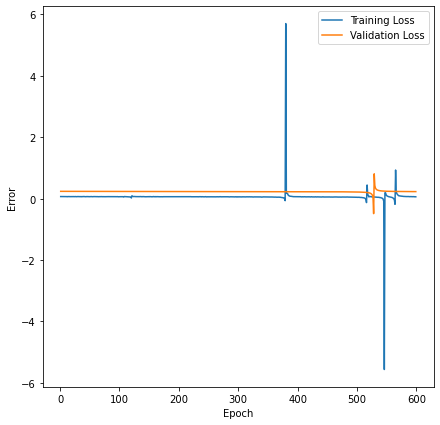

In [44]:
learning_rate = 0.00001
# regularization_rate = 0.01
epochs = 600
batch_size = 500
validation_split = 0.1

selected = list(train.columns)
selected.remove("datetime")
selected.remove("total")
selected.remove("leftovers")
selected.remove("smoothed_leftovers")
label_name = "smoothed_leftovers"

on_full_data = True
if on_full_data:
    X_train, y_train = train[selected], train[label_name]
else:
    X_train, X_test, y_train, y_test = train_test_split(train[selected], train[label_name], shuffle=True, test_size=0.1)

feature_cross_feature_layer = layers.DenseFeatures(feature_columns)#, kernel_regularizer=regularizers.L1(regularization_rate))
my_model = create_model(learning_rate, feature_cross_feature_layer)
epochs, rmse, history = train_model(
    my_model, X_train, y_train, epochs, batch_size, validation_split)

# ['loss', 'tf_error', 'val_loss', 'val_tf_error']
plot_the_loss_curves(epochs, history["tf_error"],
                    history["val_tf_error"])

# epochs, rmse = train_model(my_model, train[selected], epochs, batch_size, label_name)
# plot_the_loss_curve(epochs, rmse)

# print("\n: Evaluate the new model against the test set:")
# evaluate_model(my_model, X_test, y_test, batch_size)

Consider rewriting this model with the Functional API.


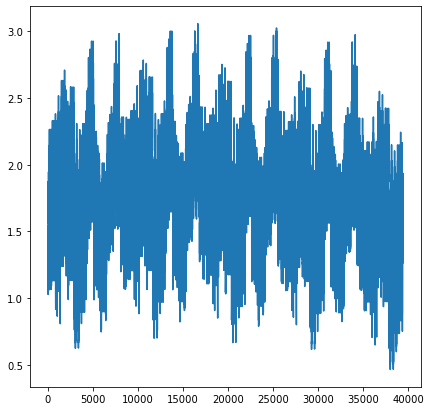

In [45]:
prediction = predict_model(my_model, pd.concat([train[selected], X_submit]), batch_size).T[0]
plt.plot(prediction)
plt.show()

In [46]:
end_prediction = prediction + extended
if not on_full_data:
    a = np.array(original_total)[len(X_test):]
    b = end_prediction[len(X_test):]
    print(np_error(a, b))
    plt.plot(a)
    plt.show()
    plt.plot(b)
    plt.show()
    plt.plot(a - b)
    plt.show()

In [47]:
with open("answer.txt", "w") as f:
    for v in end_prediction:
        f.write(str(v))
        f.write('\n')